In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
X = pd.read_csv("X_train_NHkHMNU.csv")
y = pd.read_csv("y_train_ZAN5mwg.csv")

# Merge both datasets
df = pd.concat([X, y], axis=1)

# Drop the second-to-last column if needed
df = df.drop(df.columns[-2], axis=1)

In [ ]:
df_fr = df[df["COUNTRY"] == "FR"]
df_de = df[df["COUNTRY"] == "DE"]

In [ ]:
df.columns

Index(['DAY_ID', 'COUNTRY', 'DE_CONSUMPTION', 'FR_CONSUMPTION',
       'DE_FR_EXCHANGE', 'FR_DE_EXCHANGE', 'DE_NET_EXPORT', 'FR_NET_EXPORT',
       'DE_NET_IMPORT', 'FR_NET_IMPORT', 'DE_GAS', 'FR_GAS', 'DE_COAL',
       'FR_COAL', 'DE_HYDRO', 'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR',
       'DE_SOLAR', 'FR_SOLAR', 'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE',
       'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'DE_WIND',
       'FR_WIND', 'DE_TEMP', 'FR_TEMP', 'GAS_RET', 'COAL_RET', 'CARBON_RET',
       'TARGET'],
      dtype='object')

## Bivariate Analysis

#### Partie à faire
- correlation matrix, spearman and pearson, for all and fr
- Il faudrait, comparer le comportement de features selon le comportement d'une feature en particulier
- Créer des classes sur une colonne et regarder la distribution des prix selon les classes
- faire des scatter plots (features/features, features/target)
avec ces scatter plot il serait intéressant de repérer des seuils (exemple relation Solar/target qui change à partir d'un certain moment)
plots x vs TARGET
corrélation locale par quantile.

introduis des variables “seuil” (X * (X>seuil))
mesure Spearman avant/après.

corrélation locale par quantile.
- Comparaison prix FR/ALL for same Day_Id
- Commencer à regarder des combinaisons de variables qui semble apporter de l'information

- Regarder si des variables non-linéaires peuvent être plus informative
- 

Before having a deeper comprehension of some relations we will have a general overview of the correlations between the variables.

In [ ]:
df_fr["TARGET"].describe()

count    851.000000
mean       0.046026
std        1.023512
min       -6.519268
25%       -0.178023
50%       -0.003619
75%        0.174344
max        7.786578
Name: TARGET, dtype: float64

In [ ]:
df_de["TARGET"].describe()

count    643.000000
mean       0.148044
std        1.047022
min       -3.075929
25%       -0.324693
50%        0.005057
75%        0.386596
max        7.138604
Name: TARGET, dtype: float64

### Pearson Correlation

First we will look at the pearson correlations between the different variables. This corelation mesure the linearity relation between two variable.

#### France:

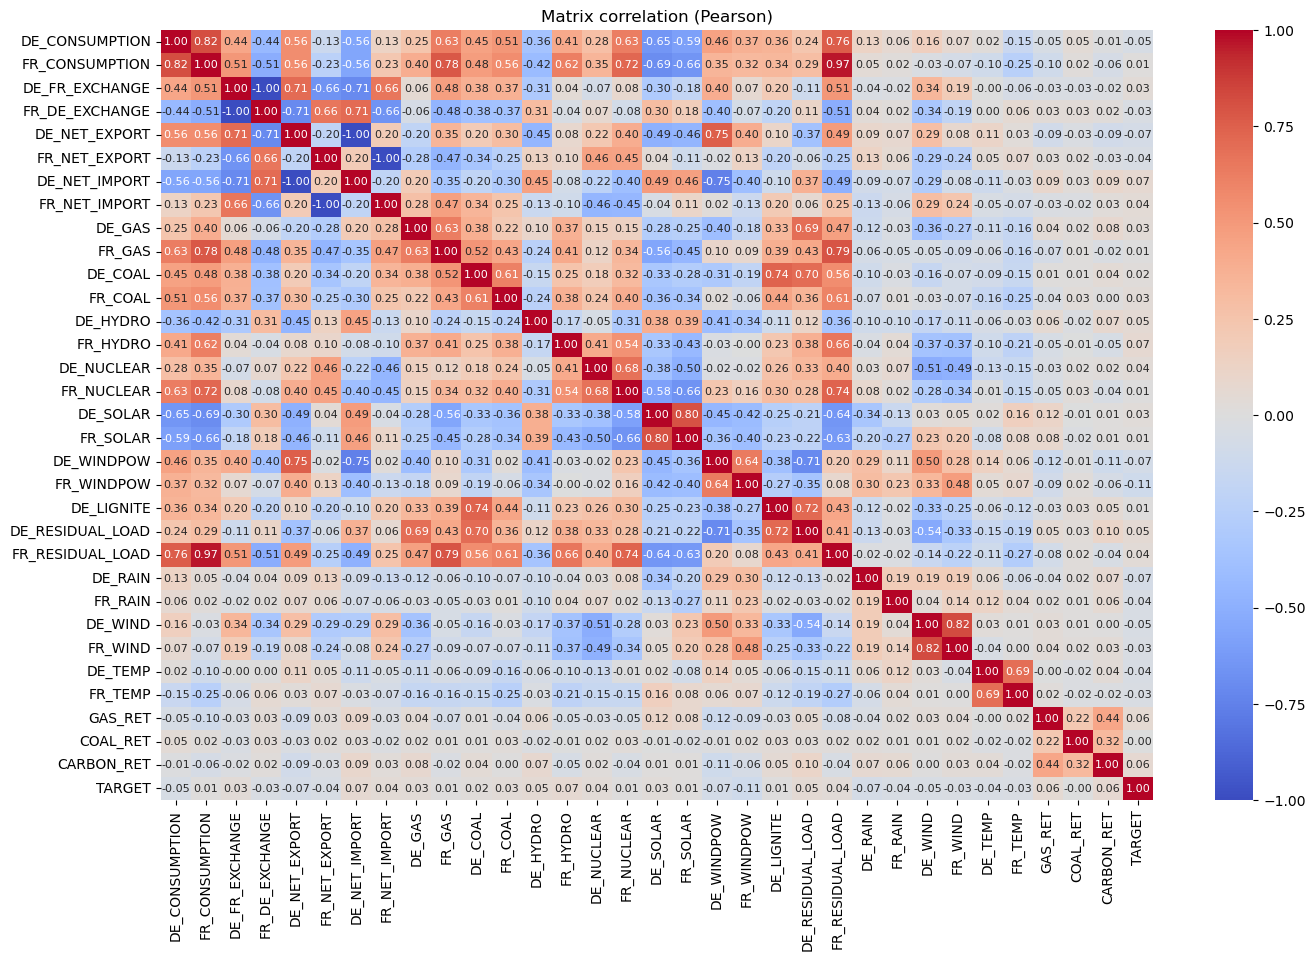

In [ ]:
df_fr_continuous = df_fr.drop(columns = ["COUNTRY", "DAY_ID"])

corr_pearson_fr = df_fr_continuous.corr(method='pearson')

plt.figure(figsize=(16, 10))
sns.heatmap(corr_pearson_fr, cmap='coolwarm', center=0, annot=True,fmt=".2f", annot_kws={"size": 8})
plt.title("Matrix correlation (Pearson)")
plt.show()


From this first view, several point are important:
- First the Target has very low pearson correlations with the other variable, that will make the prediction relevant, especially with model like linear regression.
- Some variable are just the opposite of each other, with correlations of -1, it's logical since we have variable like FR_DE_EXCHANGE and DE_FR_EXCHANGE, we will remove some of to avoid multicolinearity.
- Except the variable which are pefectly negatively correlated, only two other variable are highly correlated(abs(correlation) > 0.85), it's FR_RESIDUAL_LOAD which is the electricity consumed after the use of all renouvable energy, with FR_CONSUMPTION which is total electicity consumed. That's a big difference comparing to the deutch case where the two correspondant features have only a correlation of 0.24.
- More generaly the french and deutch variable have not the same correlations, that indicate the two system work differently.

Faire fonction pour sprtir les > 75

#### Germany:

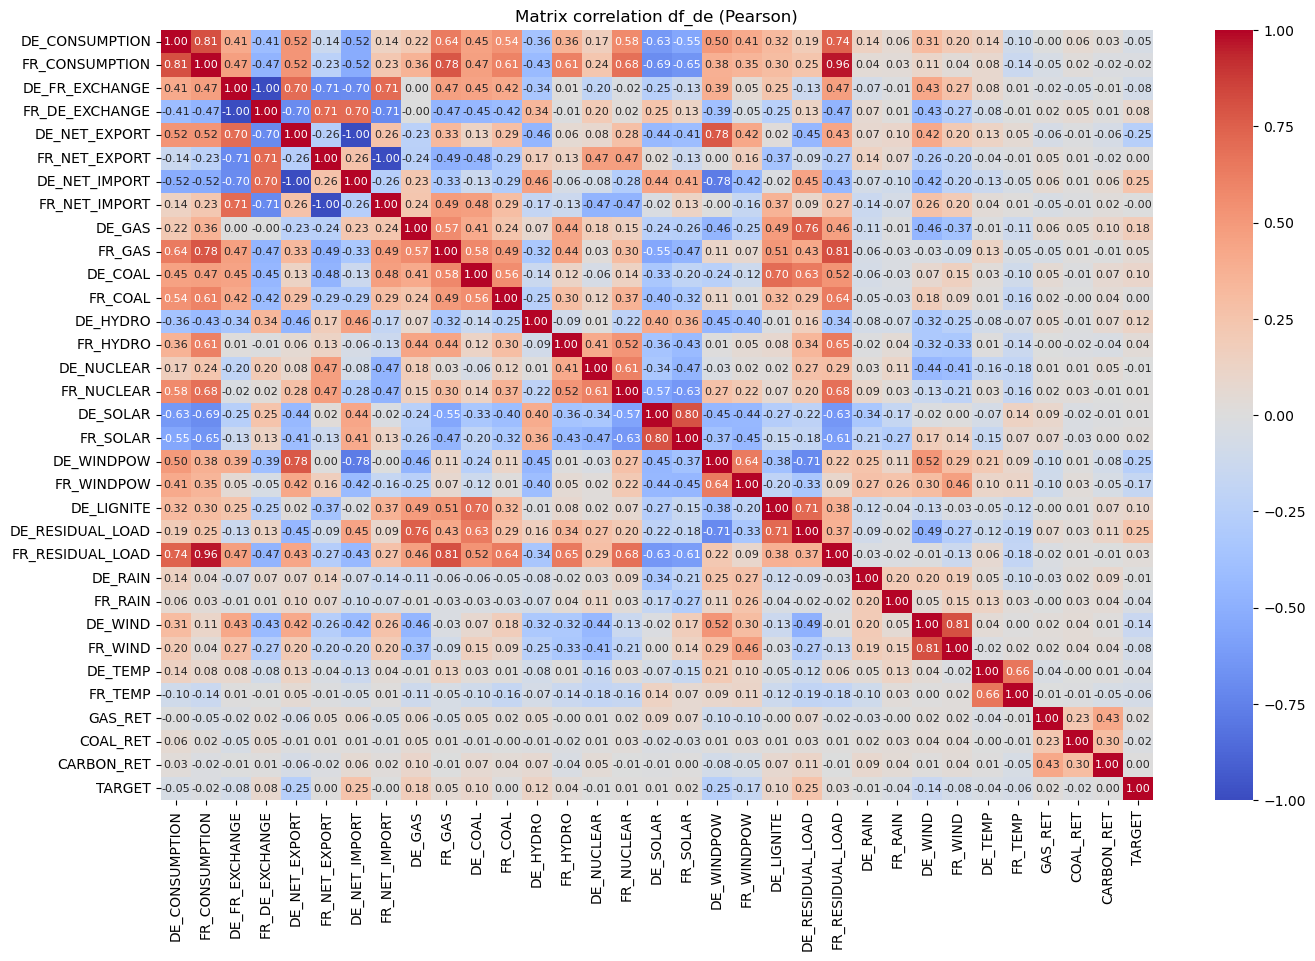

In [ ]:
df_de_continuous = df_de.drop(columns = ["COUNTRY", "DAY_ID"])

corr_pearson_de = df_de_continuous.corr(method='pearson')

plt.figure(figsize=(16, 10))
sns.heatmap(corr_pearson_de, cmap='coolwarm', center=0, annot=True,fmt=".2f", annot_kws={"size": 8})
plt.title("Matrix correlation df_de (Pearson)")
plt.show()

The correlations between the variable are pretty from what we had with the french dataset, however in this dataframe the Target is not the same (it's now the price of the deutch electricity). The correlations between the different features and the target are in general hogher than in the df_fr, especially with the deutsh variable (DE_NET_IMPORT, DE_WINDPOW,...) which seems pretty logical. These observations really renforced the idea that the french and german prices can't be explain in the same way, with the same variables. It coud be interesting to have two different models.

### Spearman Correlation

We recall that our metric to optimise is the Spearman correlation, that mesure the relations between the order of our predictions and the order of the true values. It's why it's interesting to check also the spearman correlations between the variables.

#### France:

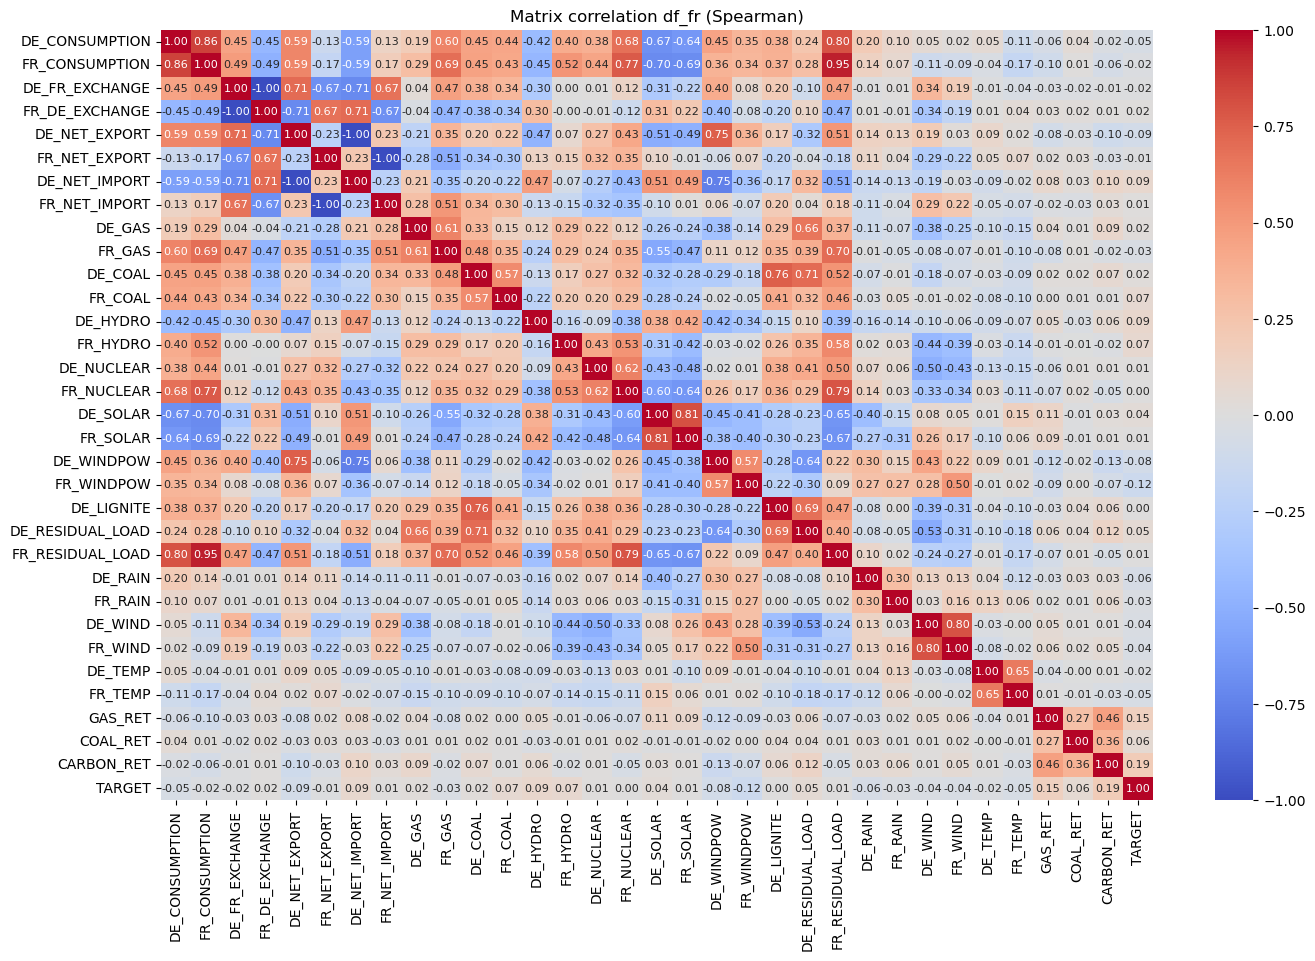

In [ ]:
corr_spearman_fr = df_fr_continuous.corr(method='spearman')
plt.figure(figsize=(16, 10))
sns.heatmap(corr_spearman_fr, cmap='coolwarm', center=0, annot=True,fmt=".2f", annot_kws={"size": 8})
plt.title("Matrix correlation df_fr (Spearman)")
plt.show()


In [24]:
corr_target = corr_spearman_fr["TARGET"]
selected_features = corr_target[abs(corr_target) > 0.08]
print(selected_features)

DE_NET_EXPORT   -0.085175
DE_NET_IMPORT    0.085175
DE_HYDRO         0.087350
DE_WINDPOW      -0.080487
FR_WINDPOW      -0.121530
GAS_RET          0.148956
CARBON_RET       0.191809
TARGET           1.000000
Name: TARGET, dtype: float64


In [ ]:
print(f"Valeur absolue moyenne corrélation Pearson featutes/targets: {abs(corr_pearson_fr.iloc[-1].iloc[:-1]).mean()}")
print(f"Valeur absolue moyenne corrélation Spearman featutes/targets: {abs(corr_spearman_fr.iloc[-1].iloc[:-1]).mean()}")

Valeur absolue moyenne corrélation Pearson featutes/targets: 0.04136248788460518
Valeur absolue moyenne corrélation Spearman featutes/targets: 0.04809161801876165


we observe correlations between variables and target that are a little bit higher comparing to the pearson correlations, notably with GAS_RET or CARBON_RET, that show  that some non-linear relations exist.

#### Germany:

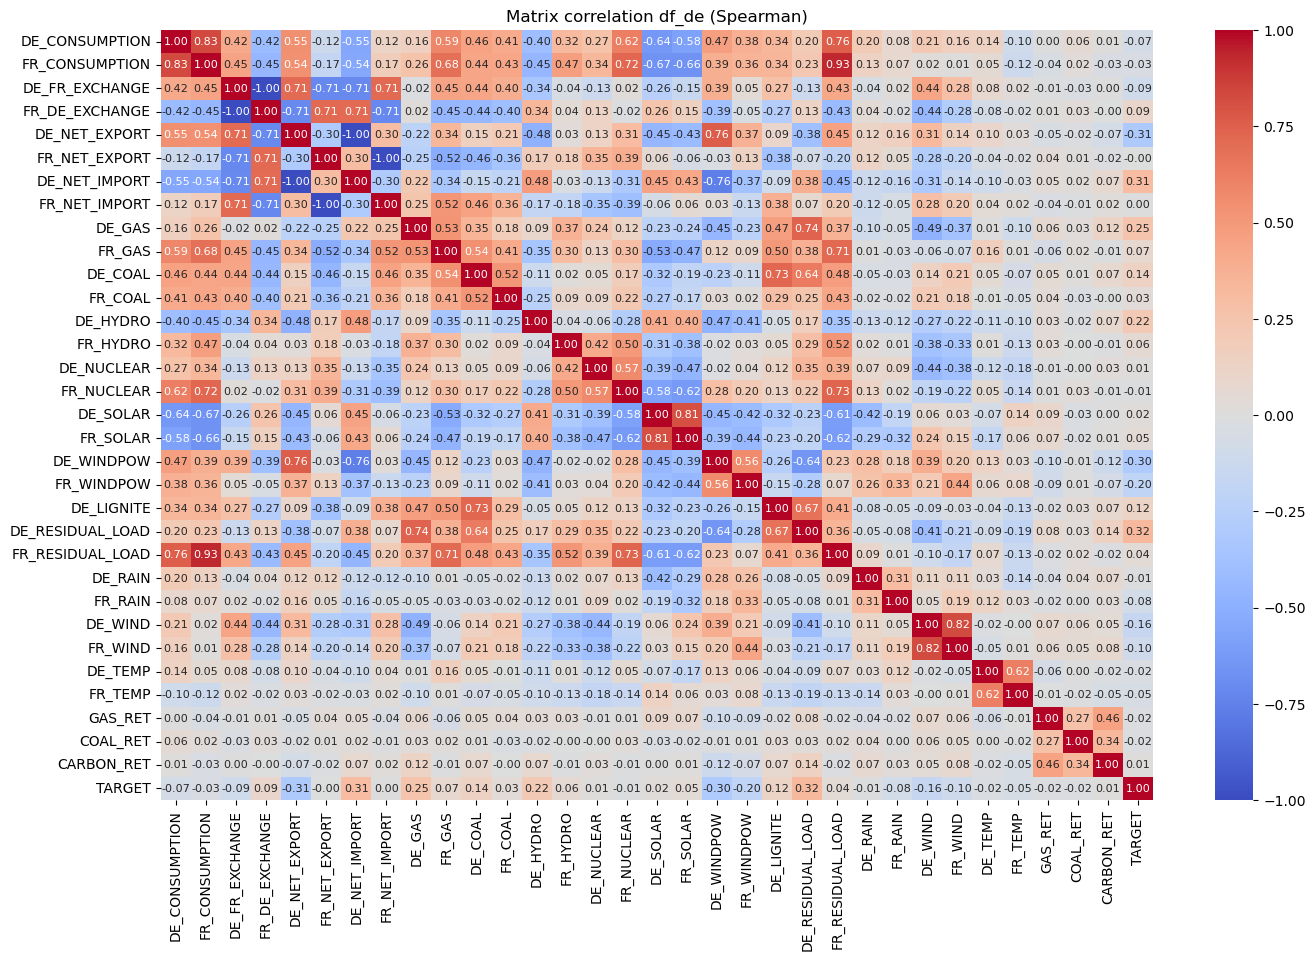

In [ ]:
corr_spearman_de = df_de_continuous.corr(method='spearman')
plt.figure(figsize=(16, 10))
sns.heatmap(corr_spearman_de, cmap='coolwarm', center=0, annot=True,fmt=".2f", annot_kws={"size": 8})
plt.title("Matrix correlation df_de (Spearman)")
plt.show()

In [23]:
corr_target_de = corr_spearman_de["TARGET"]
selected_features = corr_target_de[abs(corr_target_de) > 0.12]
print(selected_features)

DE_NET_EXPORT      -0.306204
DE_NET_IMPORT       0.306204
DE_GAS              0.253410
DE_COAL             0.142054
DE_HYDRO            0.217900
DE_WINDPOW         -0.300933
FR_WINDPOW         -0.199820
DE_LIGNITE          0.124605
DE_RESIDUAL_LOAD    0.324335
DE_WIND            -0.162500
TARGET              1.000000
Name: TARGET, dtype: float64


In [ ]:
print(f"Valeur absolue moyenne corrélation Pearson featutes/targets: {abs(corr_pearson_de.iloc[-1].iloc[:-1]).mean()}")
print(f"Valeur absolue moyenne corrélation Spearman featutes/targets: {abs(corr_spearman_de.iloc[-1].iloc[:-1]).mean()}")

Valeur absolue moyenne corrélation Pearson featutes/targets: 0.07813471622953036
Valeur absolue moyenne corrélation Spearman featutes/targets: 0.1015791993138224


That's the same constat for the deutsch dataframe, but with hogher correlations coefficient, and again that's the deutsh variable that have the highest correlations with the target (that's logical however, in df_fr the same observation can't be done).

## Finding some non-linear relations between features and Target 

We saw that the features in their basic form don't have strong and linear relations with the target. In this part we will try to find any interesting relation between features and target, by doing different types of analysis. 
- Searching threshold, above which relations exists. For exemple using the article "Drivers of electricity price dynamics: Comparative analysis of spot and futures markets" https://www.sciencedirect.com/science/article/abs/pii/S0301421518307432 it's saying that the wind has an influence on the price only when superior to a certain quantity.
- Searching if some combination of variables can have relations with the target.
- Another interesting thing would be to look if we could transform a continuous variable into categorical one, and looking if the relations between the other features and the target changes through the different category

### Searching of the threshold for df_fr

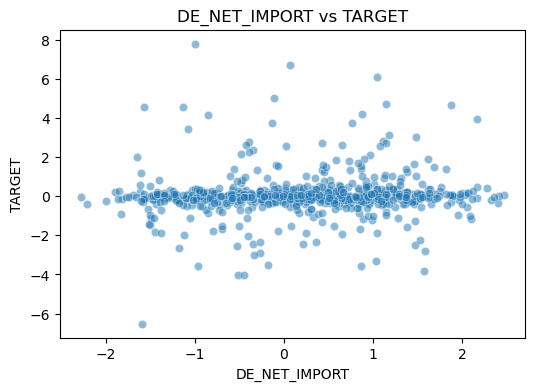

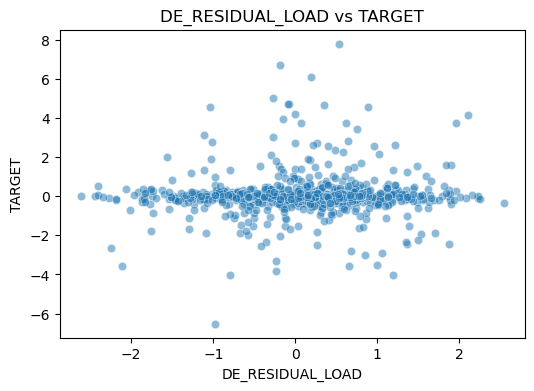

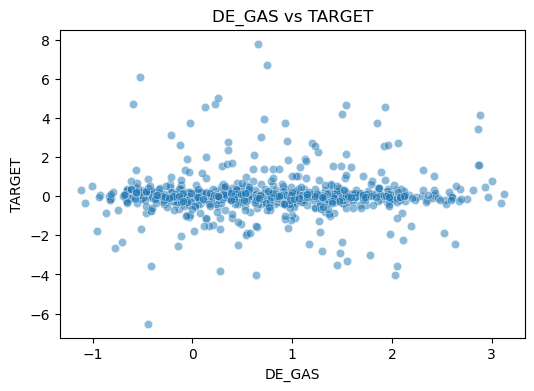

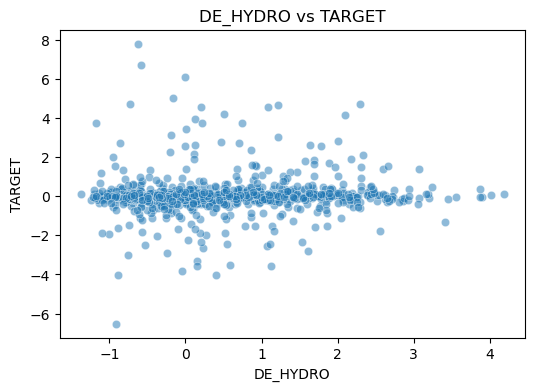

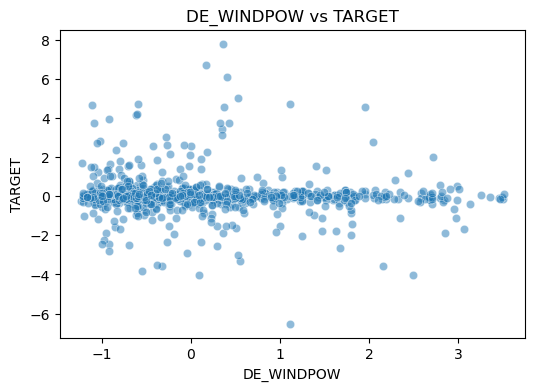

In [ ]:
features = ["DE_NET_IMPORT", "DE_RESIDUAL_LOAD", "DE_GAS", "DE_HYDRO", "DE_WINDPOW"]

for feat in features:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=df_fr[feat], y=df_fr["TARGET"], alpha=0.5)
    plt.title(f"{feat} vs TARGET")
    plt.show()



We can observe very poor relationship, furthermore there are a lot of outliers that make the visualisations (this observation is the same for all the features not only the ones that are presented here) and the interpretation very difficult. It's why we will observe the rolling median, and try to observe some visible abowe which the median seems to have a solid relation with the price. We observe the median and not the mean because we search to optimize the spearman correlations so the ordre our our predictions with the true values.

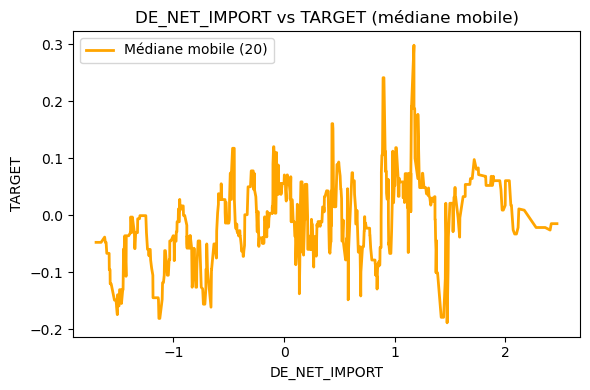

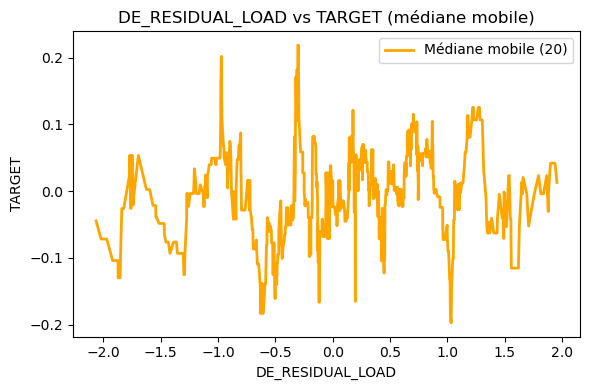

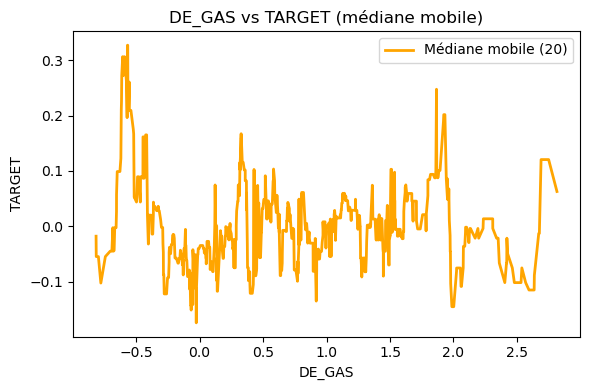

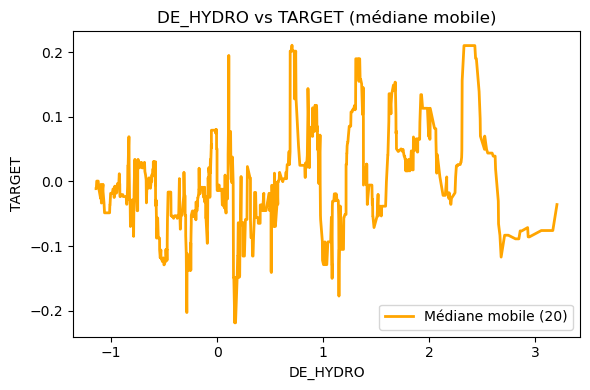

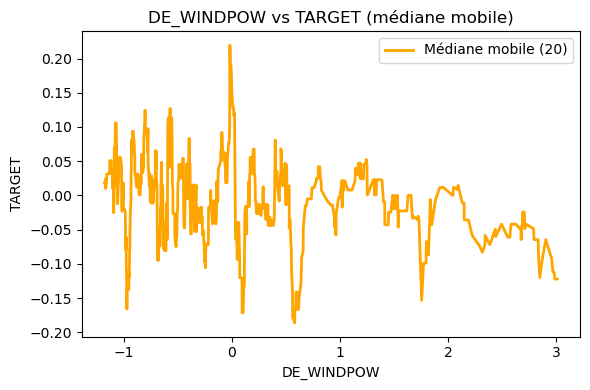

In [ ]:
window = 20

for feat in features:
    plt.figure(figsize=(6,4))
    sorted_df = df_fr[[feat, "TARGET"]].sort_values(by=feat)
    
    # Remplace rolling mean par rolling median
    rolling_median = sorted_df["TARGET"].rolling(window=window, center=True).median()
    
    plt.plot(sorted_df[feat], rolling_median, color="orange", linewidth=2, label=f'Médiane mobile ({window})')
    plt.title(f"{feat} vs TARGET (médiane mobile)")
    plt.xlabel(feat)
    plt.ylabel("TARGET")
    plt.legend()
    plt.tight_layout()
    plt.show()

From these last visualisations we remark several possible theshold.
- FR_CONSUMPTION (positive correlation for FR_CONSUMPTION > 1.5)
- DE_FR_EXCHANGE (positive correlation for DE_FR_EXCHANGE > 1.7)
- FR_HYDRO (positive for < -0.4)
- COAL_RET (Positive correlation for COAL_RET < -0.8)
- CARBON_RET (Positive correlation in [-2, 2])
- DE_NET_IMPORT (Positive correlation for DE_NET_IMPORT < 1.2)
- FR_NUCLEAR (Positive correlation for FR_NUCLEAR < -1.8)
- DE_WINDPOW (Negative Correlation for DE_WINDPOW > 1.1)
- GAS_RET (Positive correlation for GAS_RET in [-1.8, 1.6])


In [ ]:
import pandas as pd
import numpy as np

thresholds = {"FR_CONSUMPTION": (1.5, None), "DE_FR_EXCHANGE": (1.7, None), "FR_HYDRO": (None, -0.4), "COAL_RET": (None, -0.8),
    "CARBON_RET": (-2, 2),  "DE_NET_IMPORT": (None, 1.2),  "FR_NUCLEAR": (None, -1.8), "DE_WINDPOW": (1.1, None), "GAS_RET": (-1.8, 1.8)}
spearman_results = {}

for var, (low, high) in thresholds.items():
    if low is not None and high is not None:
        df_sel = df_fr[(df_fr[var] >= low) & (df_fr[var] <= high)]
    elif low is not None:
        df_sel = df_fr[df_fr[var] >= low]
    elif high is not None:
        df_sel = df_fr[df_fr[var] <= high]
    else:
        df_sel = df_fr.copy()

    n_filtered = len(df_sel)
    corr_global = df_fr[[var, "TARGET"]].corr(method="spearman").iloc[0, 1]
    corr_filtered = ( df_sel[[var, "TARGET"]].corr(method="spearman").iloc[0, 1])

    spearman_results[var] = {"Spearman_filtered": corr_filtered,"Spearman_global": corr_global,"n_filtered": n_filtered}

results_df = pd.DataFrame(spearman_results).T
results_df = results_df[["Spearman_filtered", "Spearman_global", "n_filtered"]]
results_df = results_df.sort_values(by="Spearman_filtered", ascending=False)

print(" Spearman correlations (filtered vs global) ")
display(results_df)


 Spearman correlations (filtered vs global) 


Spearman_filtered  Spearman_global  n_filtered
COAL_RET                 0.198922         0.057616       132.0
CARBON_RET               0.178944         0.191809       802.0
GAS_RET                  0.138268         0.148956       767.0
FR_NUCLEAR               0.124255         0.004077        91.0
FR_HYDRO                 0.119733         0.071709       305.0
FR_CONSUMPTION           0.105804        -0.020299        85.0
DE_FR_EXCHANGE           0.094505        -0.015005        14.0
DE_NET_IMPORT            0.094094         0.085175       614.0
DE_WINDPOW              -0.102247        -0.080487       159.0

### Conclusion on the thresholds effects for df_fr
- **Credible threshold effects**: : `COAL_RET`, `FR_CONSUMPTION`, `FR_NUCLEAR`, maybe `FR_HYDRO`. Indeed we have an important increasing of the Spearman correlation comparing to the correlation for any value, further more thiese observations are true for an "important" number of observations.
- **No clear threshold effect**: `CARBON_RET`, `GAS_RET`, `DE_NET_IMPORT`.  
  Filtered and global correlations are similar
- For `DE_FR_EXCHANGE` number of observations respecting the theshold is to limited, we can't really interprate the result.

### Searching of the threshold for df_de

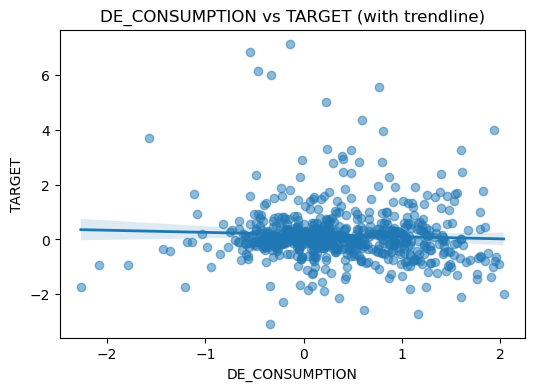

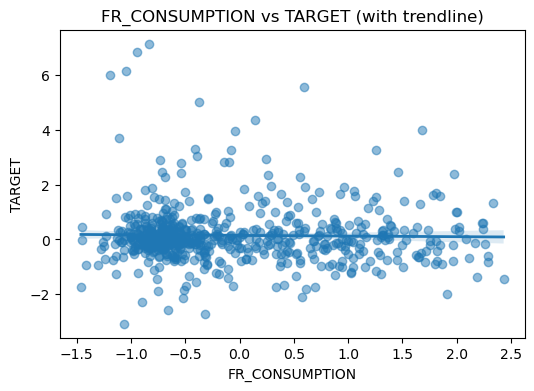

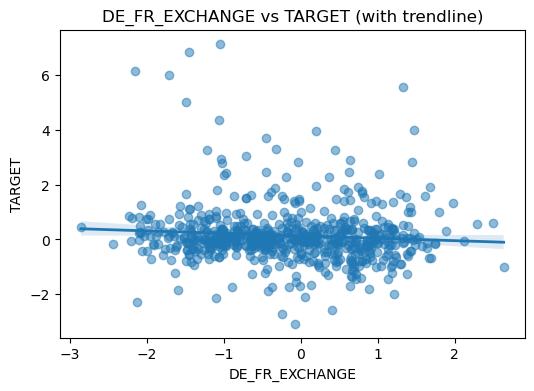

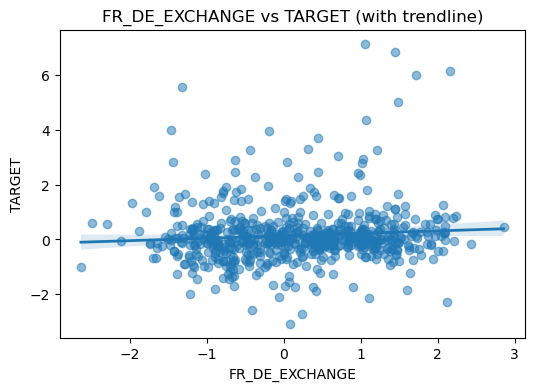

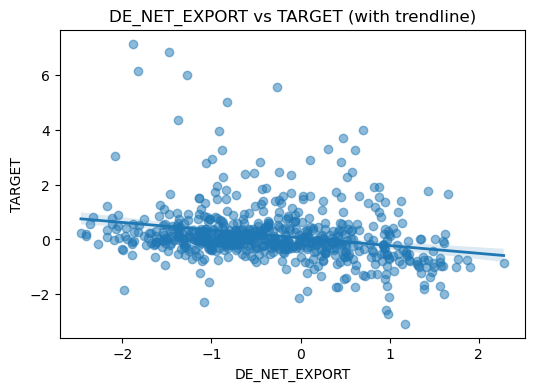

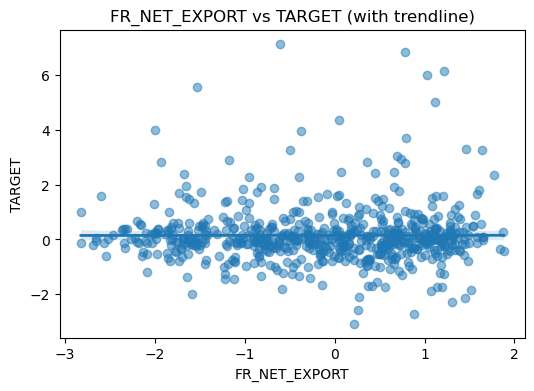

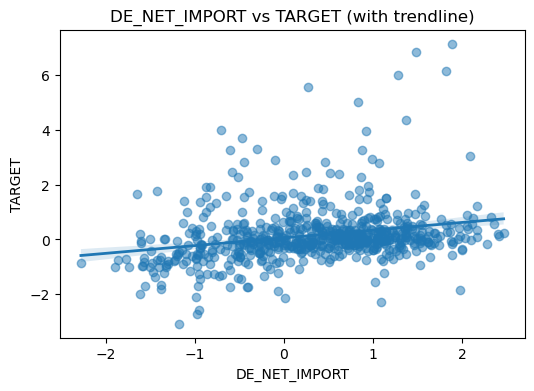

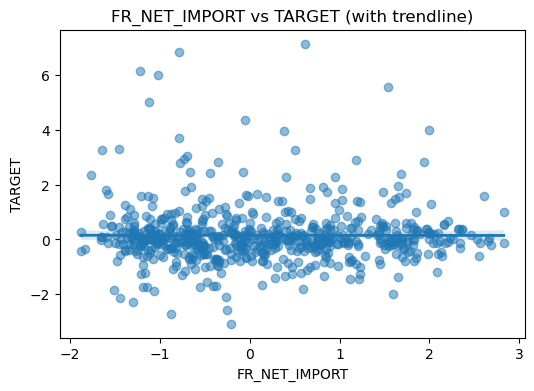

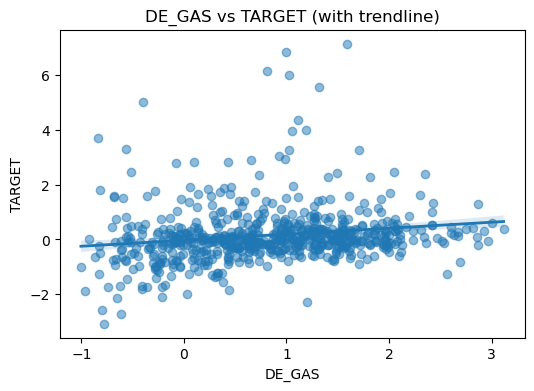

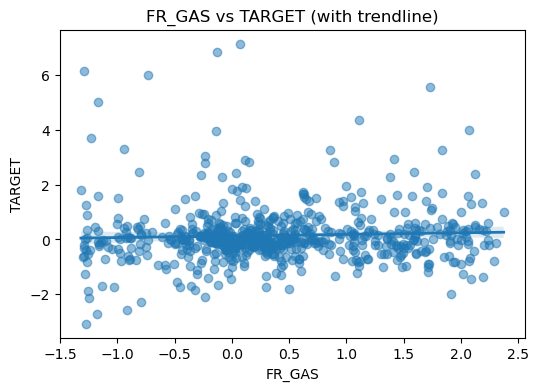

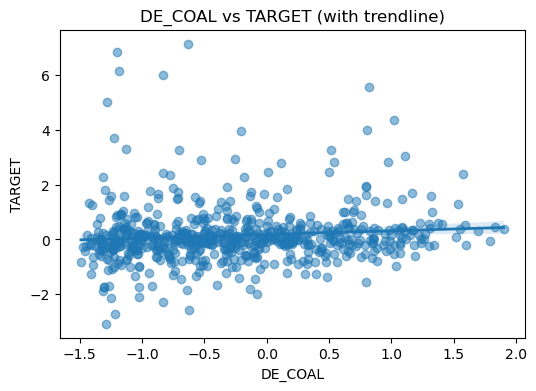

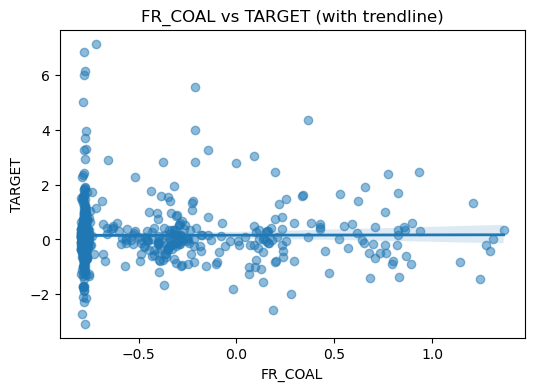

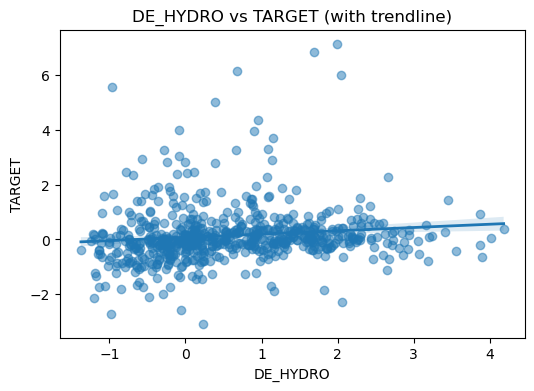

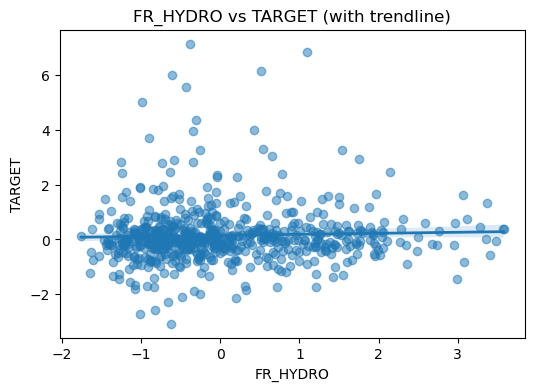

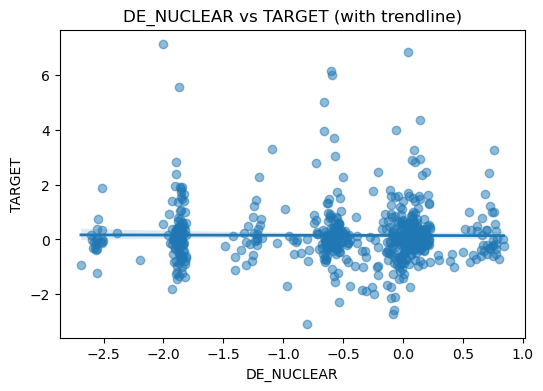

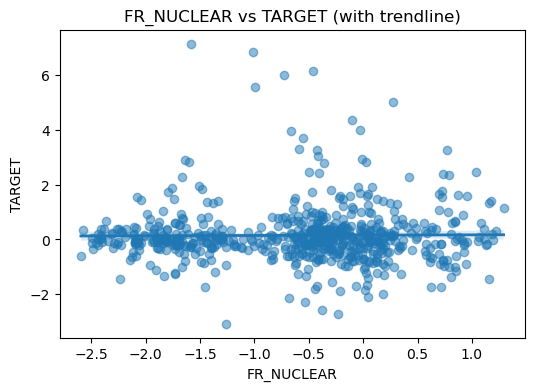

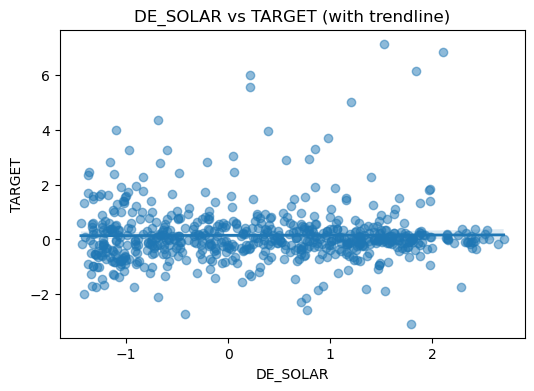

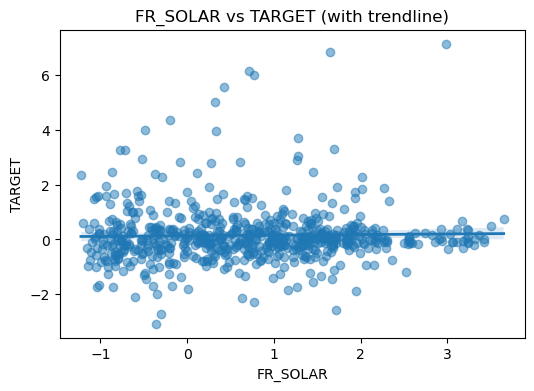

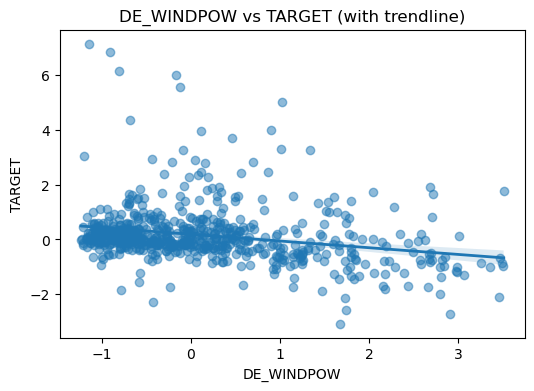

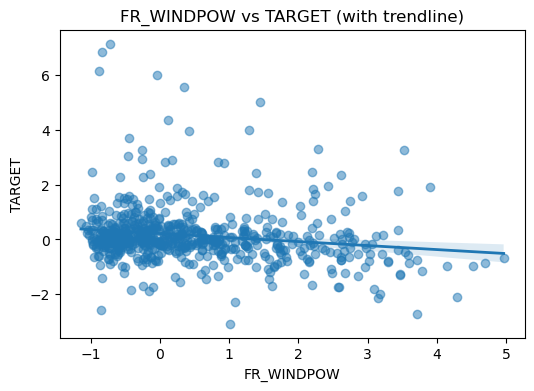

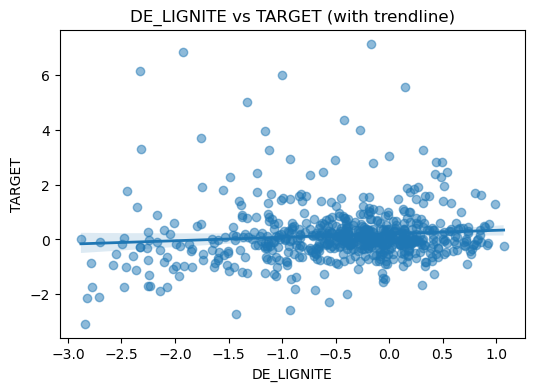

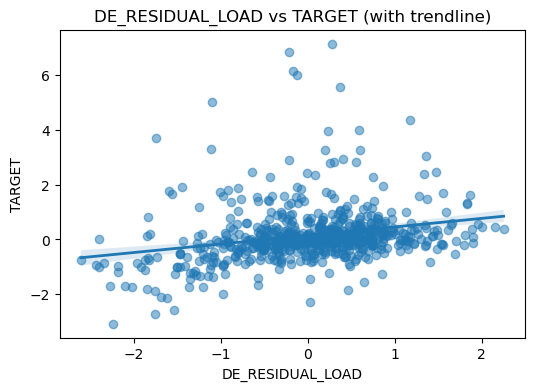

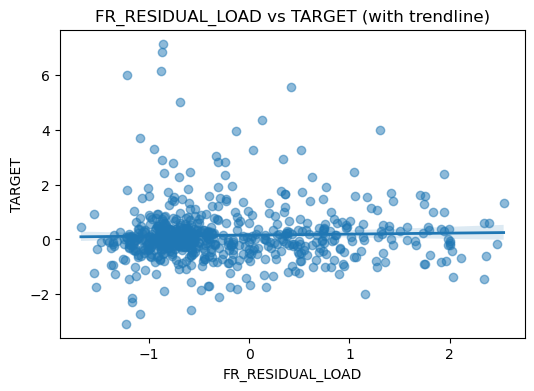

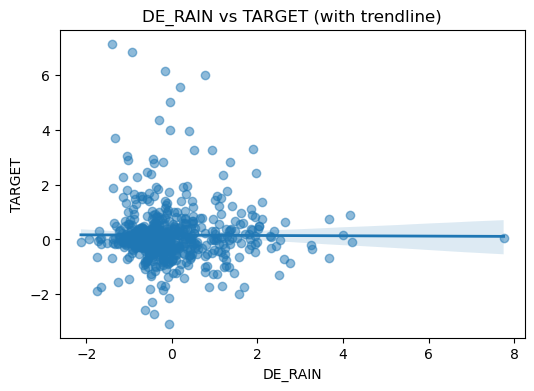

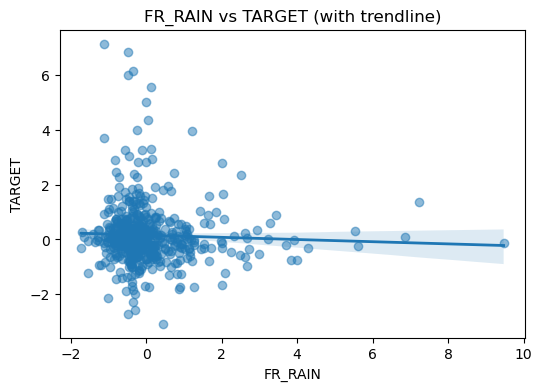

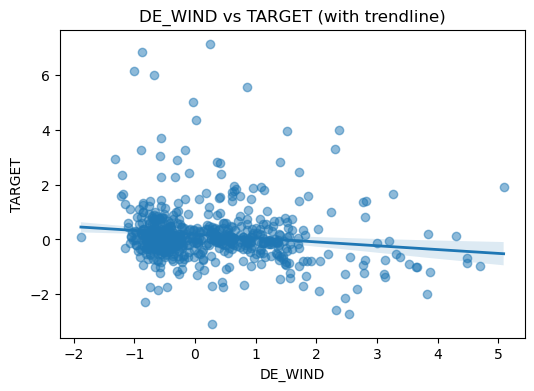

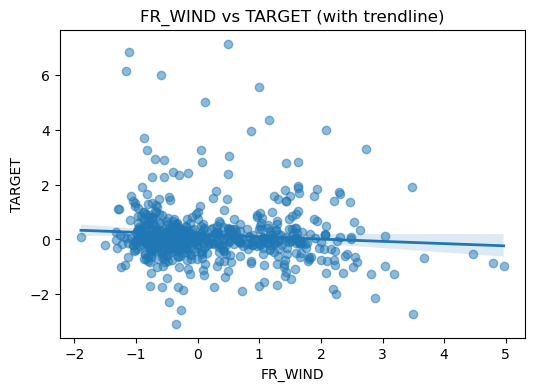

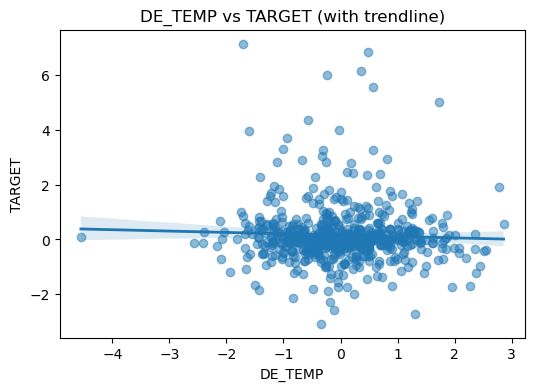

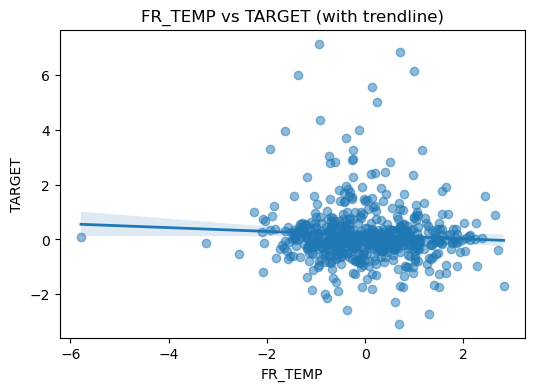

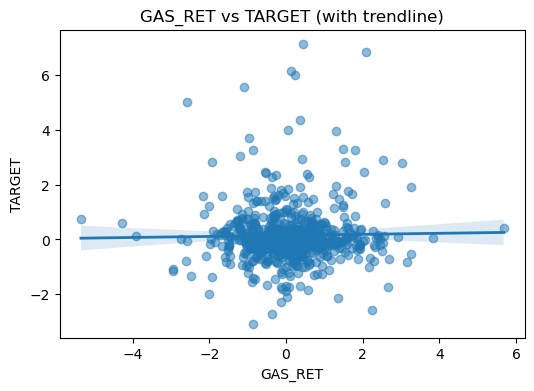

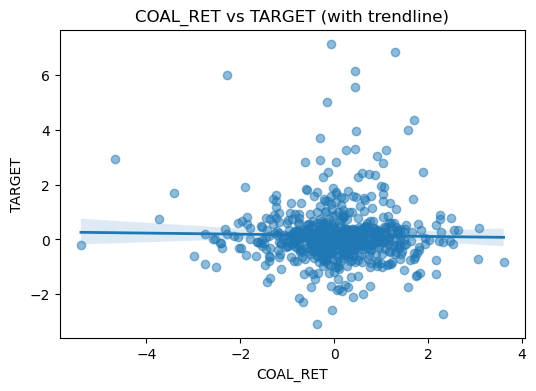

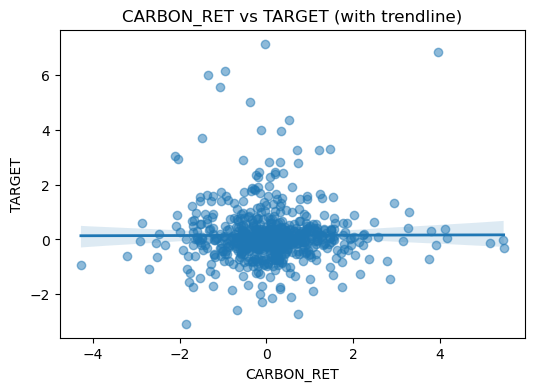

In [ ]:
features = df_fr_continuous.drop(columns="TARGET").columns

for feat in features:
    plt.figure(figsize=(6,4))
    sns.regplot(
        x=df_de[feat],
        y=df_de["TARGET"],
        scatter_kws={"alpha": 0.5},
        line_kws={"linewidth": 2}
    )
    plt.title(f"{feat} vs TARGET (with trendline)")
    plt.show()


There are more visible relationship with the deutsh target. We will also check for potential tresholds effects.

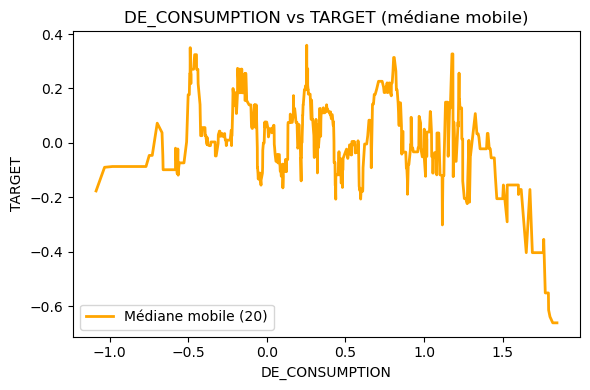

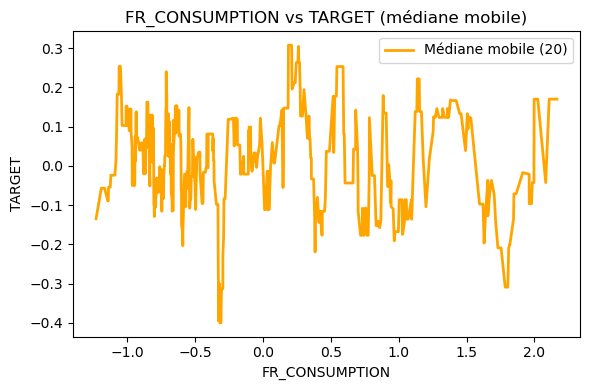

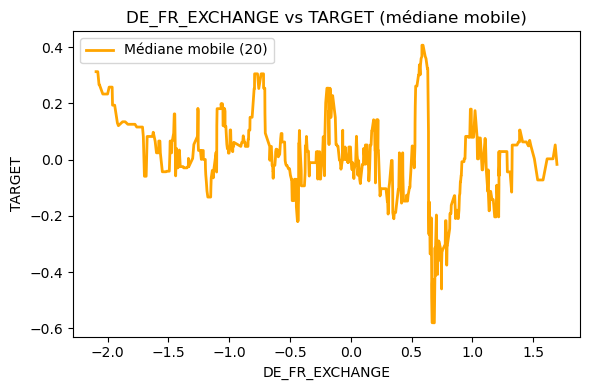

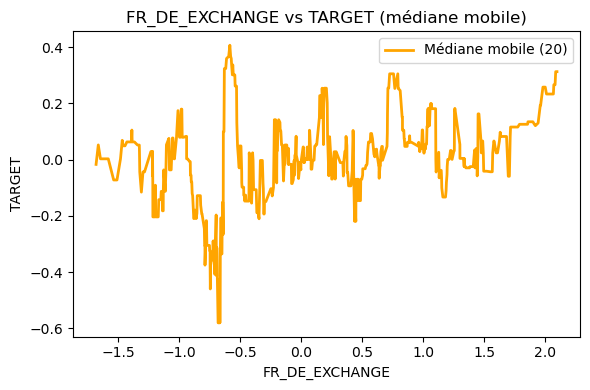

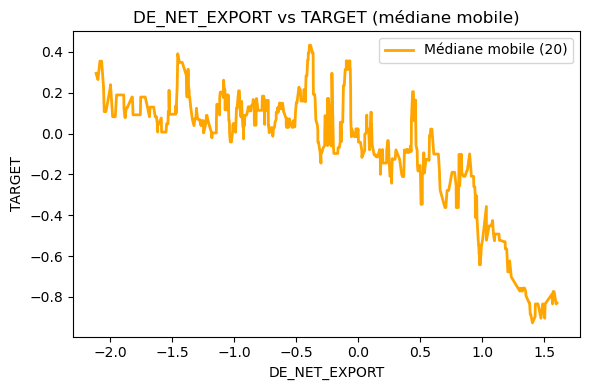

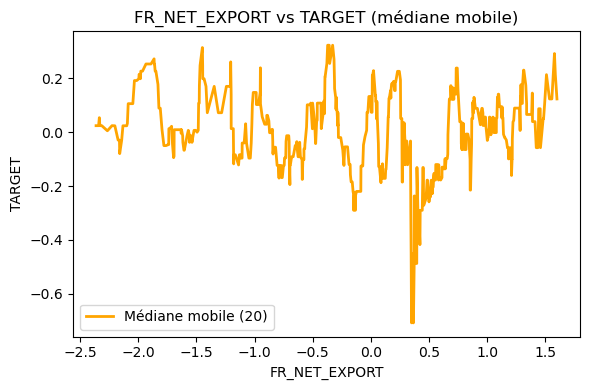

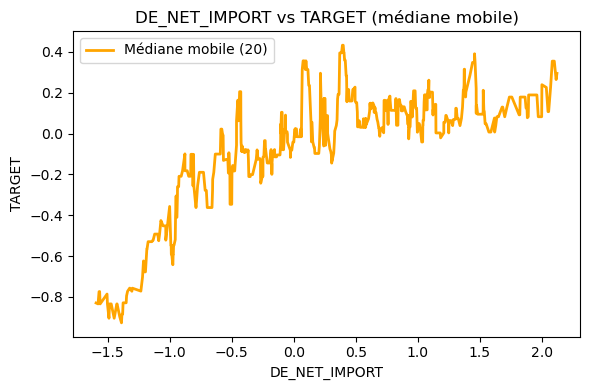

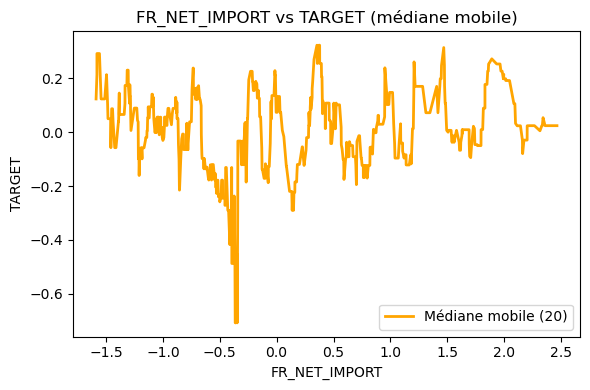

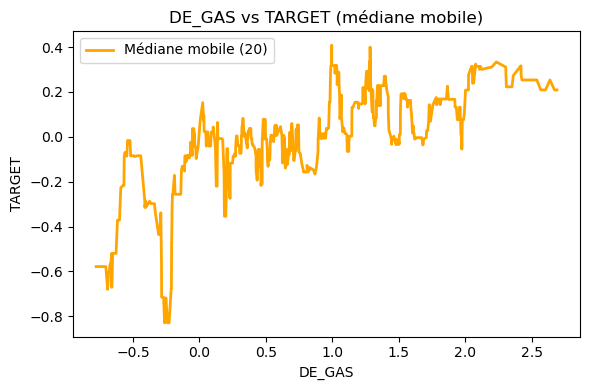

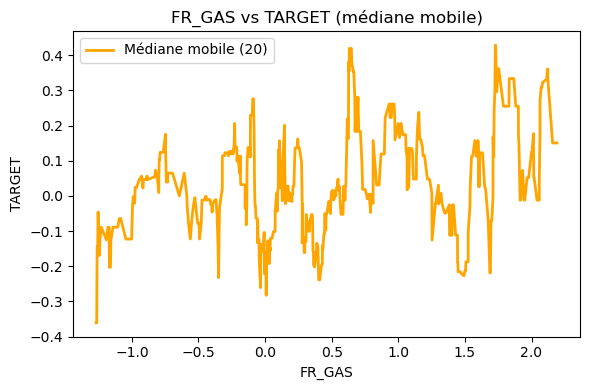

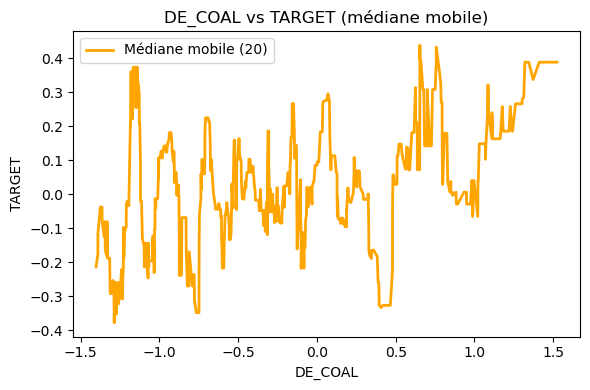

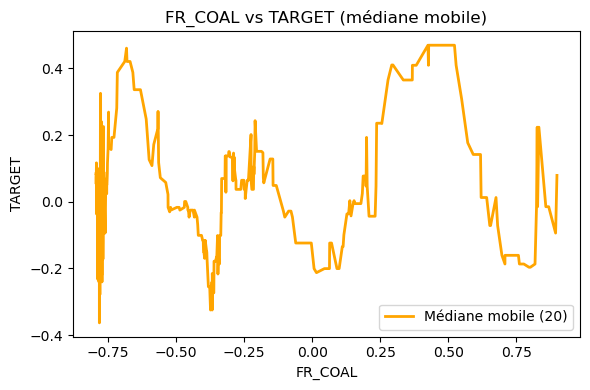

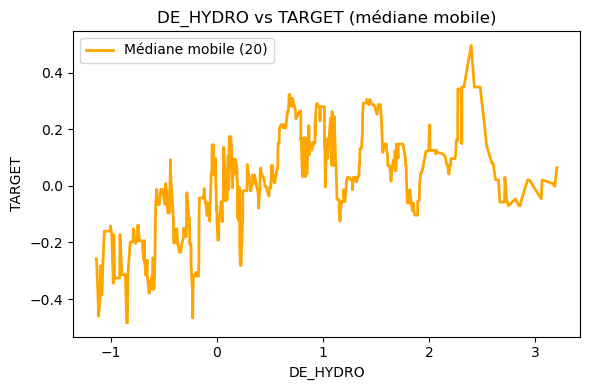

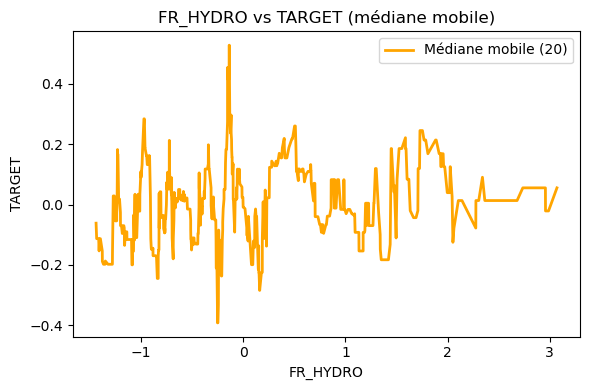

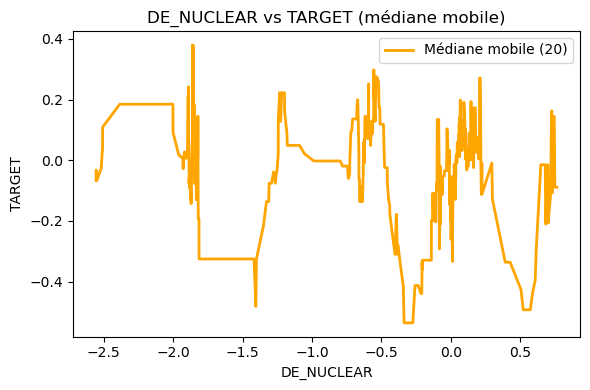

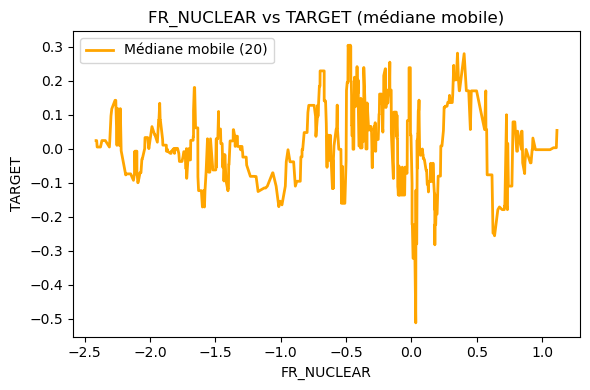

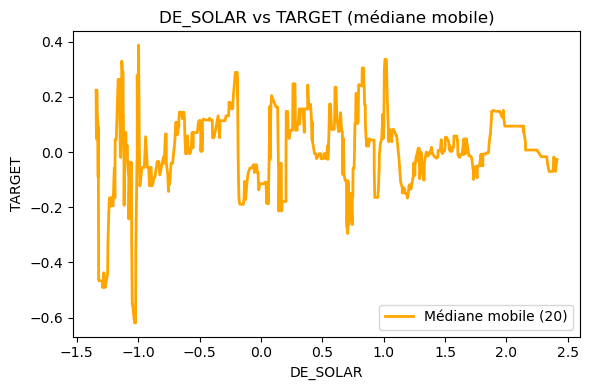

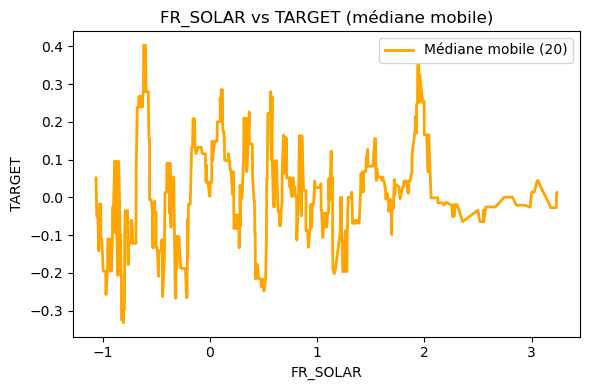

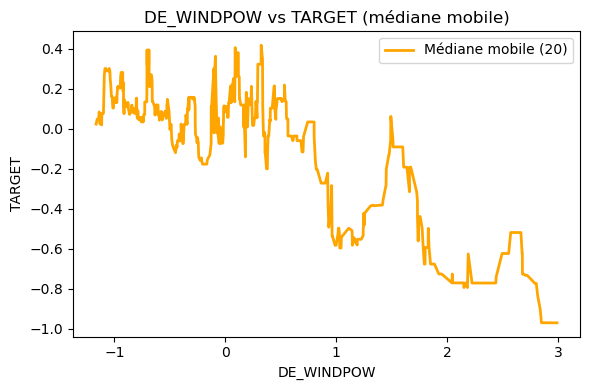

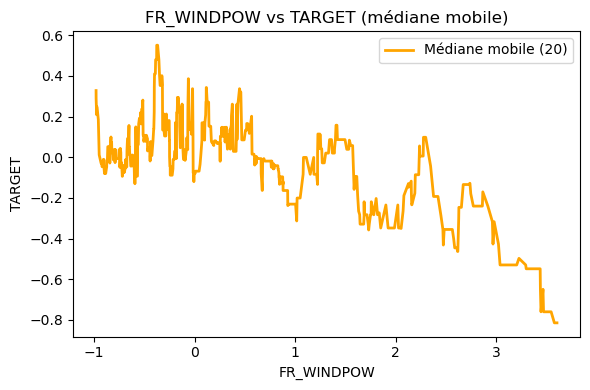

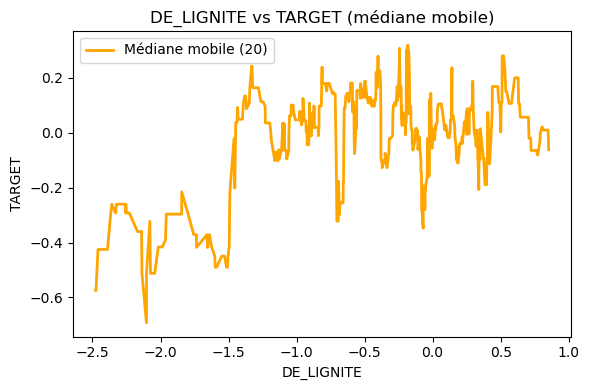

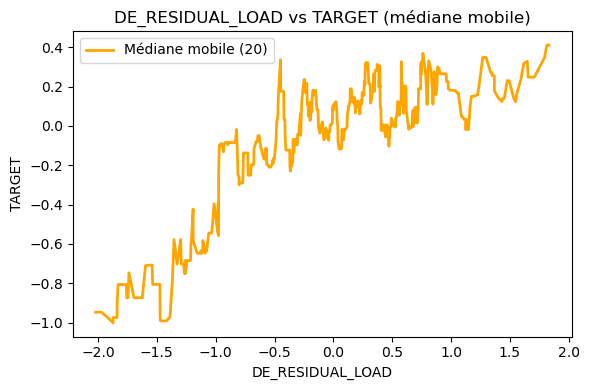

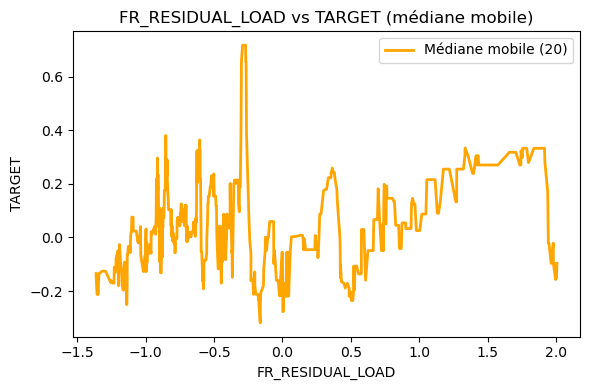

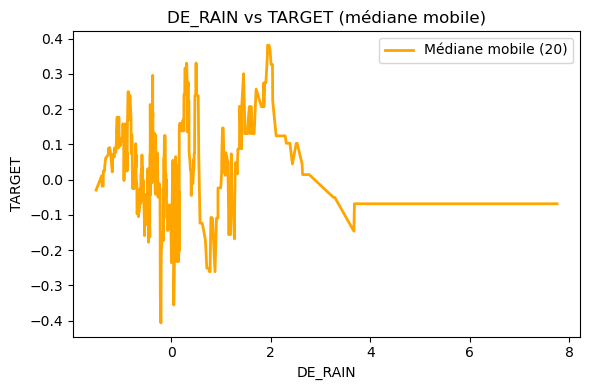

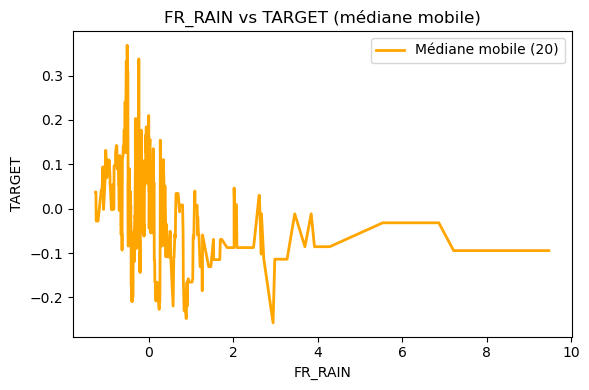

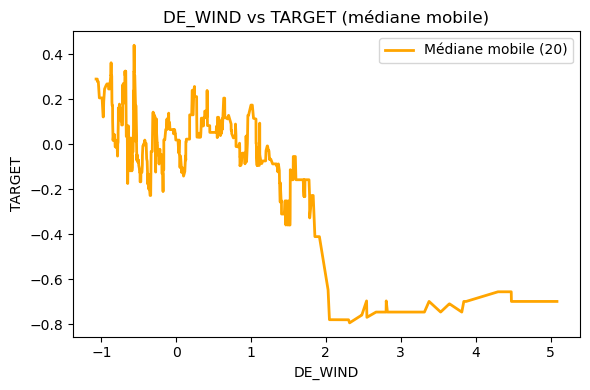

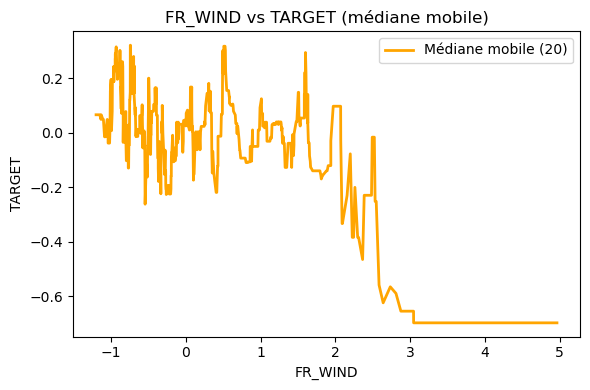

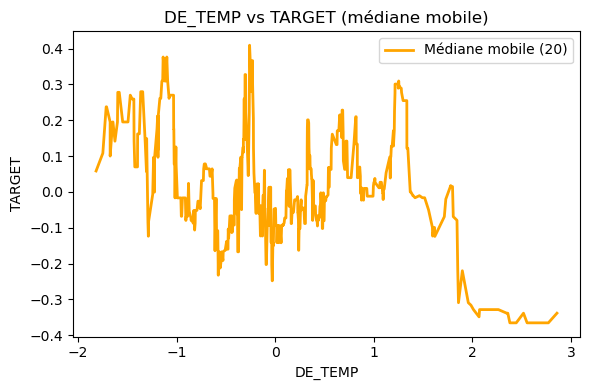

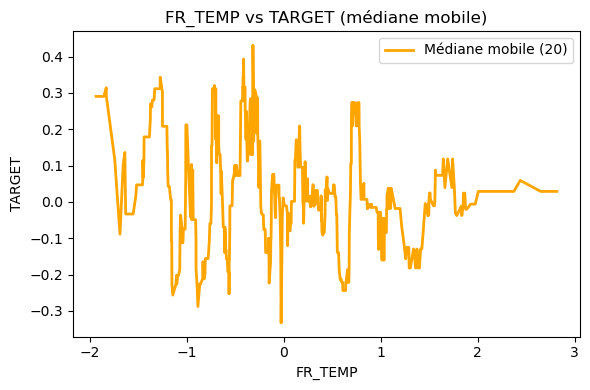

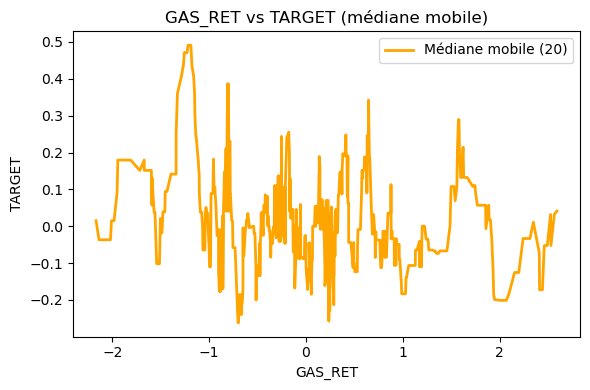

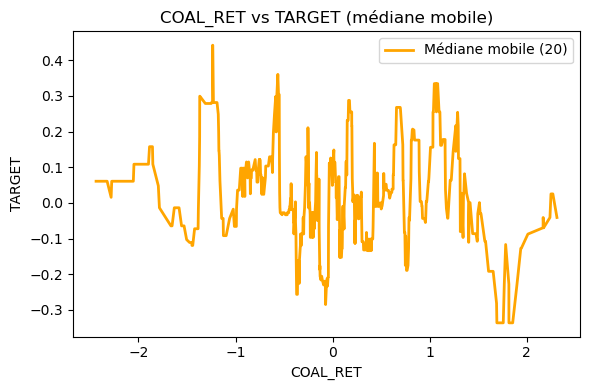

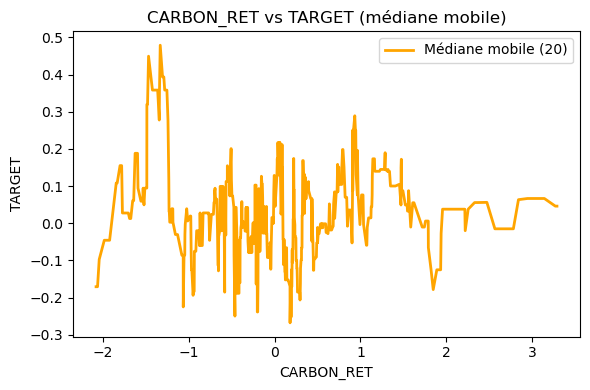

In [19]:
window = 20

for feat in features:
    plt.figure(figsize=(6,4))
    sorted_de = df_de[[feat, "TARGET"]].sort_values(by=feat)
    
    # Remplace rolling mean par rolling median
    rolling_median = sorted_de["TARGET"].rolling(window=window, center=True).median()
    
    plt.plot(sorted_de[feat], rolling_median, color="orange", linewidth=2, label=f'Médiane mobile ({window})')
    plt.title(f"{feat} vs TARGET (médiane mobile)")
    plt.xlabel(feat)
    plt.ylabel("TARGET")
    plt.legend()
    plt.tight_layout()
    plt.show()

From these last visualisations we remark several possible theshold.
- DE_CONSUMPTION (positive correlation for DE_CONSUMPTION > 1.2)
- DE_NET_EXPORT (negative correlation for DE_NET_EXPORT > -0.45)
- DE_NET_IMPORT (positive for DE_NET_IMPORT < 0.45)
- DE_HYDRO (positive correlation for DE_HYDRO < 0.7)
- DE_WINDPOW (negative correlation for DE_WINDPOW > 0.3)
- FR_WINDPOW (negative correlation for FR_WINDPOW > 0.45)
- DE_WIND (negative correlation for DE_WIND < 2)

In [20]:

thresholds_de = {
    "DE_CONSUMPTION": (1.2, None),
    "DE_NET_EXPORT": (-0.45, None),
    "DE_NET_IMPORT": (None, 0.45),
    "DE_HYDRO": (None, 0.7),
    "DE_WINDPOW": (0.3, None),
    "FR_WINDPOW": (0.45, None),
    "DE_WIND": (0.25, 2)
}

spearman_results_de = {}

for var, (low, high) in thresholds_de.items():
    # --- Apply threshold filter ---
    if low is not None and high is not None:
        df_sel = df_de[(df_de[var] >= low) & (df_de[var] <= high)]
    elif low is not None:
        df_sel = df_de[df_de[var] >= low]
    elif high is not None:
        df_sel = df_de[df_de[var] <= high]
    else:
        df_sel = df_de.copy()

    # --- Sample size ---
    n_filtered = len(df_sel)

    # --- Spearman correlations ---
    corr_global = df_de[[var, "TARGET"]].corr(method="spearman").iloc[0, 1]
    corr_filtered = df_sel[[var, "TARGET"]].corr(method="spearman").iloc[0, 1]

    # --- Store results ---
    spearman_results_de[var] = {
        "Spearman_filtered": corr_filtered,
        "Spearman_global": corr_global,
        "n_filtered": n_filtered
    }

# Turn into DataFrame
results_df_de = pd.DataFrame(spearman_results_de).T
results_df_de = results_df_de[["Spearman_filtered", "Spearman_global", "n_filtered"]]
results_df_de = results_df_de.sort_values(by="Spearman_filtered", ascending=False)

print(" Spearman correlations (filtered vs global, DE dataset) ")
display(results_df_de)



 Spearman correlations (filtered vs global, DE dataset) 


Spearman_filtered  Spearman_global  n_filtered
DE_NET_IMPORT            0.363736         0.306204       336.0
DE_HYDRO                 0.210295         0.217900       368.0
DE_WIND                 -0.176221        -0.162500       212.0
DE_CONSUMPTION          -0.178018        -0.071736        86.0
FR_WINDPOW              -0.229371        -0.199820       247.0
DE_NET_EXPORT           -0.363736        -0.306204       336.0
DE_WINDPOW              -0.391259        -0.300933       225.0

From this we will keep the different thresholds:
- DE_NET_IMPORT < 0.45
- DE_CONSUMPTION > 1.2
- DE_NET_EXPORT > -0.45
- DE_WINDPOW > 0.3


# Modèle de base

In [21]:
from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split

X_all = df.drop(columns=["TARGET", "COUNTRY"]).fillna(0)
y_all = df["TARGET"]


X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# Modèle linéaire
lr = LinearRegression()
lr.fit(X_train, y_train)

# Prédictions
y_pred_train = lr.predict(X_train)
y_pred_test  = lr.predict(X_test)

# Métrique Spearman
def spearman_corr(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation

print("Corrélation (Spearman) train : {:.1f}%".format(100 * spearman_corr(y_train, y_pred_train)))
print("Corrélation (Spearman) test  : {:.1f}%".format(100 * spearman_corr(y_test,  y_pred_test)))


Corrélation (Spearman) train : 28.9%
Corrélation (Spearman) test  : 19.5%


# Visualisaton des features

On peut voir que certaines valeurs ont une fortes assymétrie, notamment avec des queues plus longues à droite, ce qu'on appelle du skew, ceci peut être génant pour des modèles comme des régression linéaires, on va tenter de "normaliser" les variables avec du skew important

# Application de Quantile -> Normal

In [22]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr

# Colonnes à transformer
variables_skew = ['DE_WINDPOW', 'FR_WINDPOW', 'FR_CONSUMPTION', 'DE_COAL', 'FR_RESIDUAL_LOAD', 'FR_WIND', 'FR_HYDRO', 'DE_WIND']

X_all = df.drop(columns=["TARGET", "COUNTRY"]).fillna(0)
y_all = df["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

qt = QuantileTransformer(output_distribution='normal', n_quantiles=min(1000, len(X_train)), random_state=42)
qt.fit(X_train[variables_skew])

X_train[variables_skew] = qt.transform(X_train[variables_skew])
X_test[variables_skew]  = qt.transform(X_test[variables_skew])

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train_q)
y_pred_test  = lr.predict(X_test_q)

def spearman_corr(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation

print("Spearman (train) : {:.1f}%".format(100 * spearman_corr(y_train, y_pred_train)))
print("Spearman (test)  : {:.1f}%".format(100 * spearman_corr(y_test, y_pred_test)))


NameError: name 'X_train_q' is not defined

ça à l'air d'améliorer légèrement les prédictions

# Similaire mais avec création de pipeline

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import spearmanr
import joblib

# --- Fonction principale ---
def train_quantile_pipeline(df, variables_skew, test_size=0.2, random_state=42):
    
    X = df.drop(columns=["TARGET", "COUNTRY"]).fillna(0)
    y = df["TARGET"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    preprocessor = ColumnTransformer(transformers=[("quantile", QuantileTransformer(output_distribution='normal',n_quantiles=min(1000, len(X_train)),
                random_state=random_state), variables_skew), ("pass", "passthrough", [c for c in X_train.columns if c not in variables_skew])])

    pipe = Pipeline([ ("preprocessor", preprocessor), ("model", LinearRegression())])

    pipe.fit(X_train, y_train)

    y_pred_train = pipe.predict(X_train)
    y_pred_test  = pipe.predict(X_test)

    metrics = {
        "train": {
            "R2": r2_score(y_train, y_pred_train),
            "MSE": mean_squared_error(y_train, y_pred_train),
            "Spearman": spearman_corr(y_train, y_pred_train)
        },
        "test": {
            "R2": r2_score(y_test, y_pred_test),
            "MSE": mean_squared_error(y_test, y_pred_test),
            "Spearman": spearman_corr(y_test, y_pred_test)
        }
    }

    return pipe, metrics


variables_skew = ['DE_WINDPOW', 'FR_WINDPOW', 'FR_CONSUMPTION',
                  'DE_COAL', 'FR_RESIDUAL_LOAD', 'FR_WIND',
                  'FR_HYDRO', 'DE_WIND']

pipe, metrics = train_quantile_pipeline(df, variables_skew)

print(metrics)


{'train': {'R2': 0.0757943372598312, 'MSE': 0.9595585422662297, 'Spearman': 0.30372588313581117}, 'test': {'R2': -0.007174477203153895, 'MSE': 1.2029415495225775, 'Spearman': 0.19836510524667655}}


In [ ]:
print(f"Valeur absolue moyenne corrélation Pearson featutes/targets: {abs(corr_pearson.iloc[-1].iloc[:-1]).mean()}")
print(f"Valeur absolue moyenne corrélation Spearman featutes/targets: {abs(corr_spearman.iloc[-1].iloc[:-1]).mean()}")

Valeur absolue moyenne corrélation Pearson featutes/targets: 0.053521439875969606
Valeur absolue moyenne corrélation Spearman featutes/targets: 0.07002781106062123


On constate des correlations de spearman en moyenne plus importantes que celles de Pearson, ça s'explique par des relations non linéaires entre features et target.

## Regression Linéaire simple sur chaque dataframe

### France

In [ ]:
X_fr = df_fr.drop(columns=["TARGET", "COUNTRY"]).fillna(0)
y_fr = df_fr["TARGET"]


X_train, X_test, y_train, y_test = train_test_split(X_fr, y_fr, test_size=0.2, random_state=42)

# Modèle linéaire
lr = LinearRegression()
lr.fit(X_train, y_train)

# Prédictions
y_pred_train = lr.predict(X_train)
y_pred_test  = lr.predict(X_test)

# Métrique Spearman
def spearman_corr(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation

print("Corrélation (Spearman) train : {:.1f}%".format(100 * spearman_corr(y_train, y_pred_train)))
print("Corrélation (Spearman) test  : {:.1f}%".format(100 * spearman_corr(y_test,  y_pred_test)))

Corrélation (Spearman) train : 24.5%
Corrélation (Spearman) test  : 3.6%


Très mauvais résultats pour la France

In [ ]:
X_de = df_al.drop(columns=["TARGET", "COUNTRY"]).fillna(0)
y_de = df_al["TARGET"]


X_train, X_test, y_train, y_test = train_test_split(X_de, y_de, test_size=0.2, random_state=42)

# Modèle linéaire
lr = LinearRegression()
lr.fit(X_train, y_train)

# Prédictions
y_pred_train = lr.predict(X_train)
y_pred_test  = lr.predict(X_test)

# Métrique Spearman
def spearman_corr(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation

print("Corrélation (Spearman) train : {:.1f}%".format(100 * spearman_corr(y_train, y_pred_train)))
print("Corrélation (Spearman) test  : {:.1f}%".format(100 * spearman_corr(y_test,  y_pred_test)))

Corrélation (Spearman) train : 44.9%
Corrélation (Spearman) test  : 37.3%


Bien meilleur pour l'Allemagne

# Sélection des variables pour chacun des modèles.
Il est logique de s'intéresser aux variables vraiment explicatives pour les prix de chaques pays, la météo française n'est pas censé expliqué directement le prix de l'électricité allemande par exemple. On va donc s'intéresser aux corrélations de Spearman spécifiques à chaques pays.

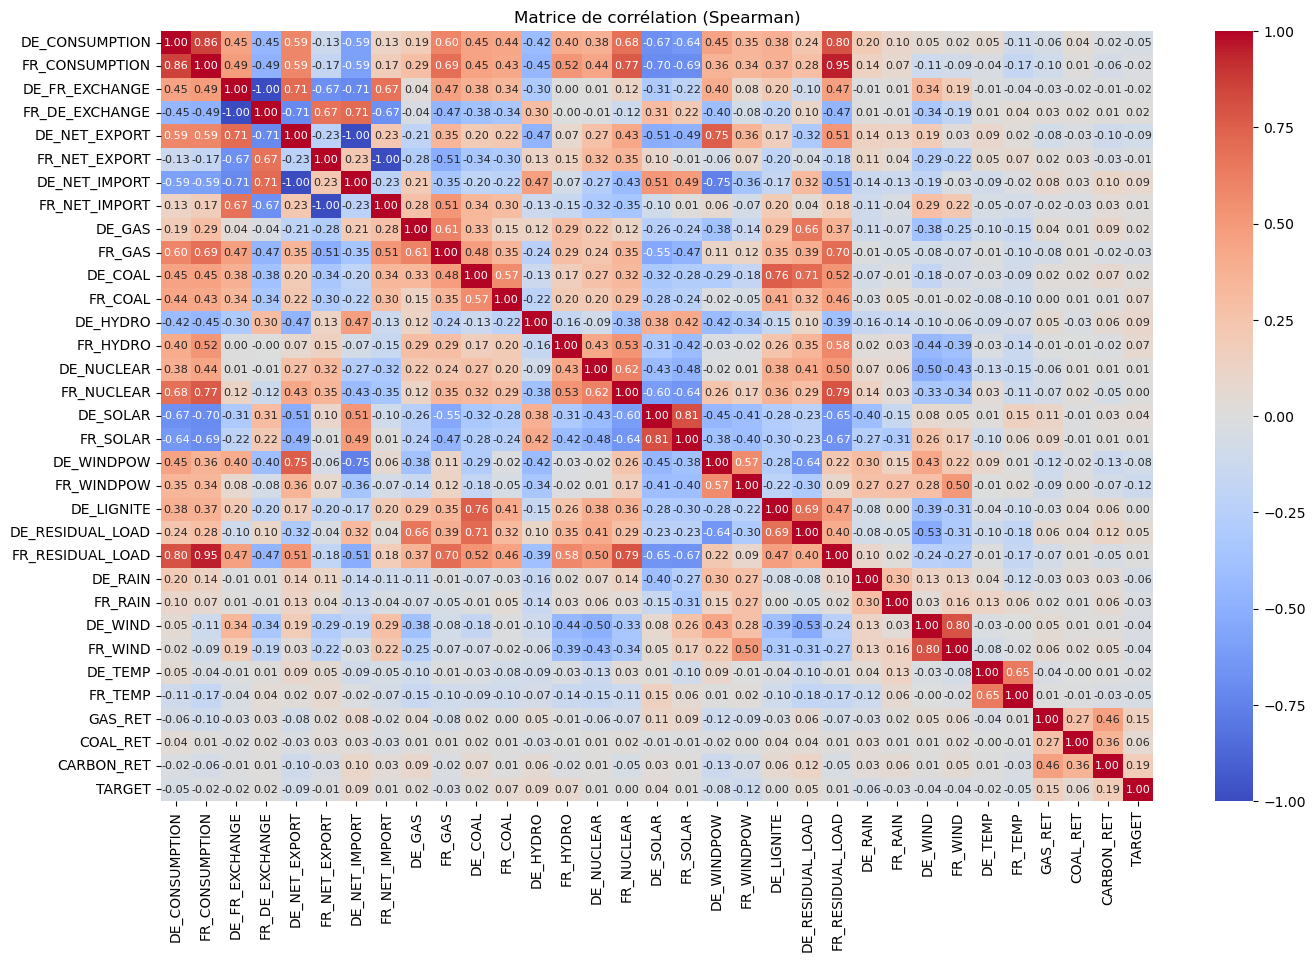

In [ ]:
df_continuous_fr = df_fr.drop(columns = ["COUNTRY", "DAY_ID"])

corr_spearman = df_continuous_fr.corr(method='spearman')

# On trace une heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(corr_spearman, cmap='coolwarm', center=0, annot=True,fmt=".2f", annot_kws={"size": 8})
plt.title("Matrice de corrélation (Spearman)")
plt.show()

Ces visualisations expliques clairement la faiblesse de notre modèle vis à vis des prédictions du prix de l'électricité fr, en effet les corrélations de spearman entre les features et Target sont extrèmement faibles, contrairement au df_al où elles sont beaucoup plus importantes. Les corrélations features/target de df_al indiquent qu'il est bien raisonnable d'enlever certaines features liées à la France. On ne va pas enlever toutes les données fr du df_al mais juste utiliser un seuil (qui enlevera majoritaire des données fr mais pas uniquement et pas toutes)

In [ ]:
corr_sup =corr_spearman_al.iloc[-1]
coll_keep_al = corr_sup[abs(corr_sup) > 0.08].index
coll_keep_al

Index(['DE_FR_EXCHANGE', 'FR_DE_EXCHANGE', 'DE_NET_EXPORT', 'DE_NET_IMPORT',
       'DE_GAS', 'DE_COAL', 'DE_HYDRO', 'DE_WINDPOW', 'FR_WINDPOW',
       'DE_LIGNITE', 'DE_RESIDUAL_LOAD', 'FR_RAIN', 'DE_WIND', 'FR_WIND',
       'TARGET'],
      dtype='object')

In [ ]:
X_de = df_al[coll_keep_al]
X_de = X_de.drop(columns="TARGET").fillna(0)
y_de = df_al["TARGET"]


X_train, X_test, y_train, y_test = train_test_split(X_de, y_de, test_size=0.2, random_state=42)

# Modèle linéaire
lr = LinearRegression()
lr.fit(X_train, y_train)

# Prédictions
y_pred_train = lr.predict(X_train)
y_pred_test  = lr.predict(X_test)

# Métrique Spearman
def spearman_corr(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation

print("Corrélation (Spearman) train : {:.1f}%".format(100 * spearman_corr(y_train, y_pred_train)))
print("Corrélation (Spearman) test  : {:.1f}%".format(100 * spearman_corr(y_test,  y_pred_test)))

Corrélation (Spearman) train : 41.4%
Corrélation (Spearman) test  : 38.2%


ça semble améliorer les performance mais reste très sensible au seuil défini (0.08 dans notre cas), fixé assez arbitrairement.

## IDEES pour expliquer mieux le prix de l'électricité française

1) Utiliser les regimes de fonctionnement (celui du nucleaire par exemple).

<Axes: xlabel='FR_NUCLEAR', ylabel='Count'>

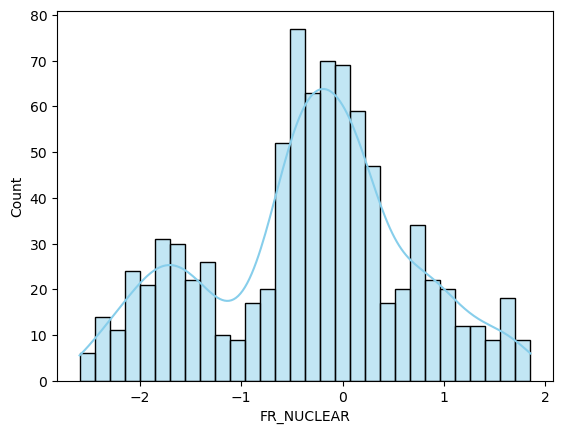

In [ ]:
sns.histplot(df_fr["FR_NUCLEAR"].dropna(), kde=True, color='skyblue', bins=30)

On distingue 3 bosses, il serait intéressant de s'intéresser aux différents comportements si l'on se trouve dans le 1er, 2e ou 3e regime. Néanmoins il faut rester générale (et bien penser à faire ju K-fold etc) pour ne pas tomber dans de l'overfitting

In [ ]:
# Création d'une colonne REGIME selon les quantiles
quantiles = df_fr["FR_NUCLEAR"].quantile([0.33, 0.66])
q1, q2 = quantiles[0.33], quantiles[0.66]

def classify_regime(x):
    if x <= q1:
        return 0  
    elif x <= q2:
        return 1 
    else:
        return 2  

df_fr["REGIME"] = df_fr["FR_NUCLEAR"].apply(classify_regime)


C:\Users\mathi\AppData\Local\Temp\ipykernel_27684\2207417278.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fr["REGIME"] = df_fr["FR_NUCLEAR"].apply(classify_regime)


In [ ]:
df_reg0 = df_fr[df_fr["REGIME"] == 0]
df_reg1 = df_fr[df_fr["REGIME"] == 1]
df_reg2 = df_fr[df_fr["REGIME"] == 2]




### Matrice de corrélations Régime 0

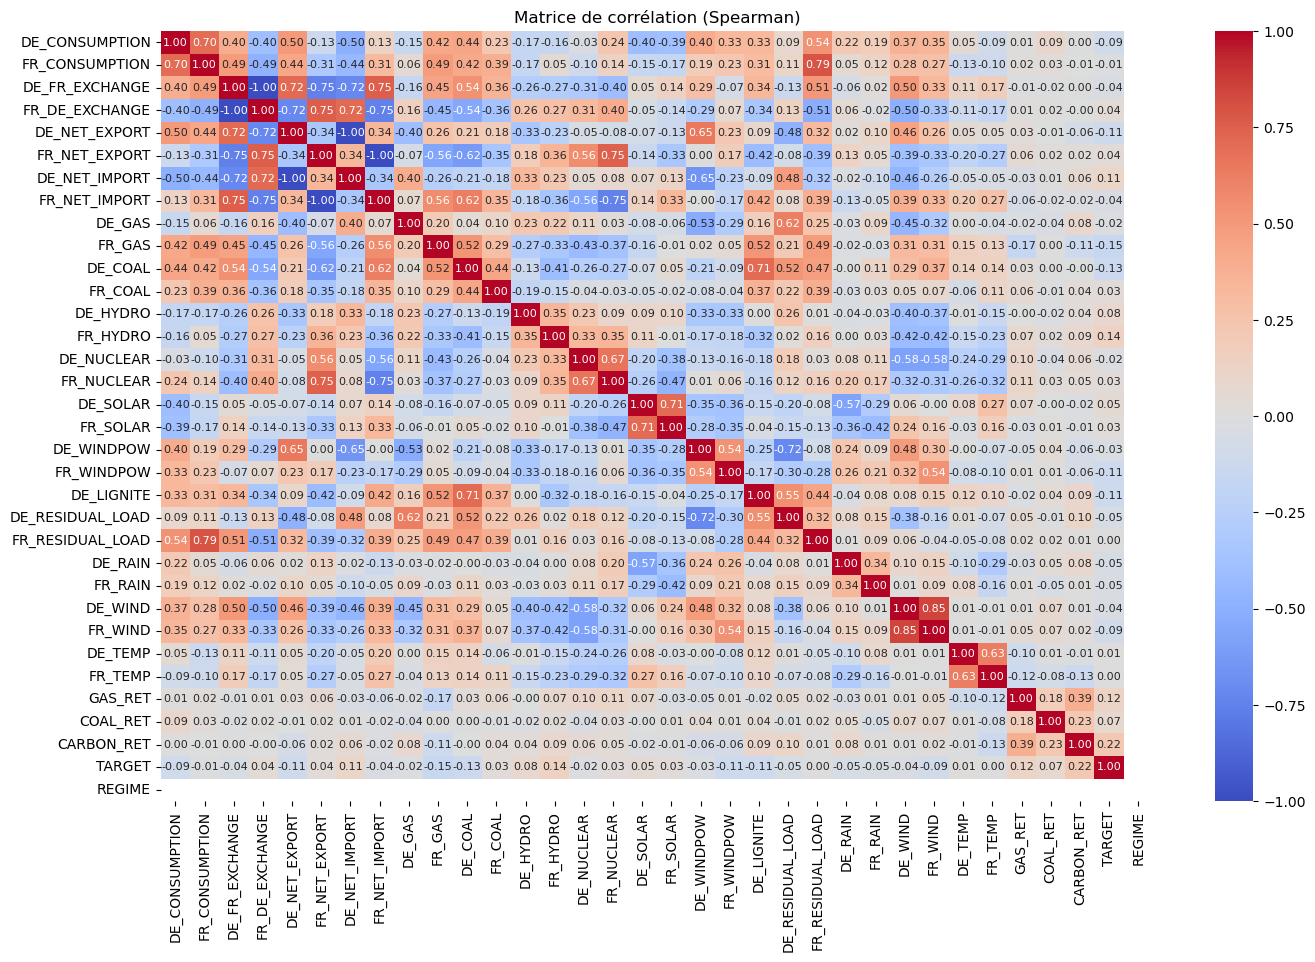

In [ ]:
df_continuous_reg0 = df_reg0.drop(columns = ["COUNTRY", "DAY_ID"])

corr_spearman = df_continuous_reg0.corr(method='spearman')

# On trace une heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(corr_spearman, cmap='coolwarm', center=0, annot=True,fmt=".2f", annot_kws={"size": 8})
plt.title("Matrice de corrélation (Spearman)")
plt.show()

### Matrice de corrélations Régime 1

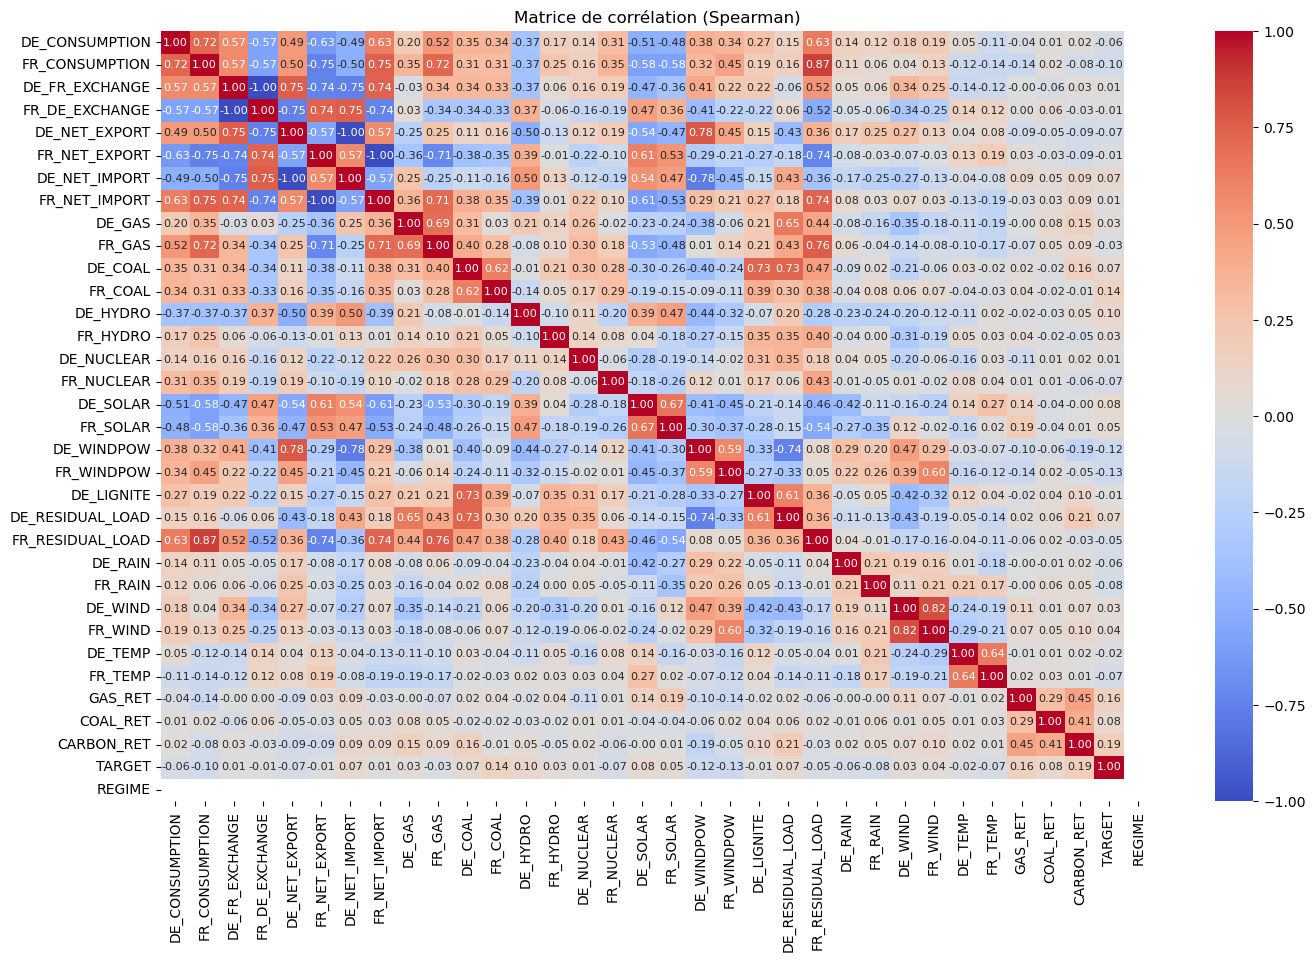

In [ ]:
df_continuous_reg1 = df_reg1.drop(columns = ["COUNTRY", "DAY_ID"])

corr_spearman = df_continuous_reg1.corr(method='spearman')

# On trace une heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(corr_spearman, cmap='coolwarm', center=0, annot=True,fmt=".2f", annot_kws={"size": 8})
plt.title("Matrice de corrélation (Spearman)")
plt.show()

### Matrice de corrélations Régime 2

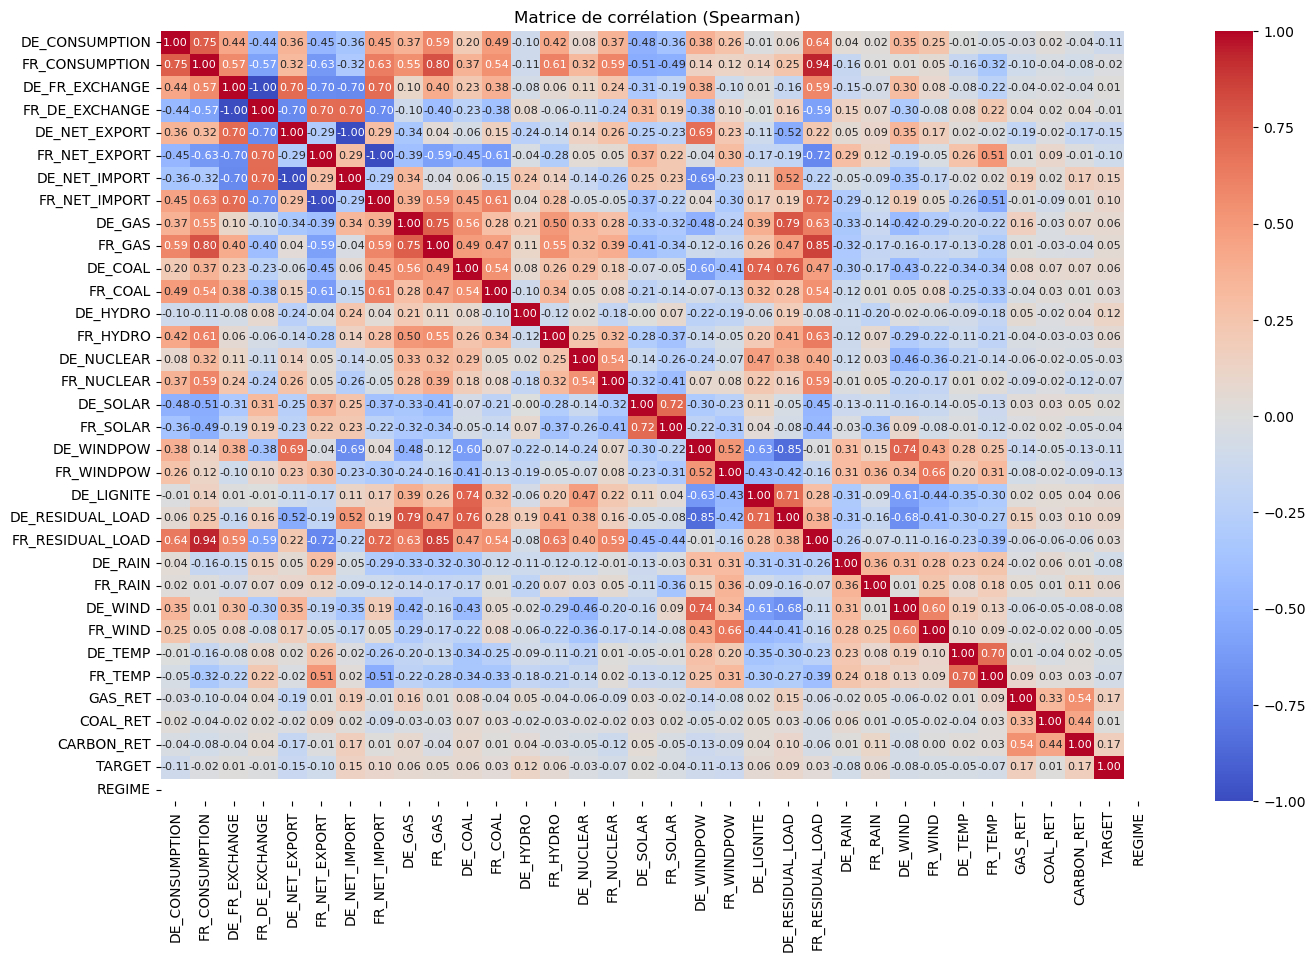

In [ ]:
df_continuous_reg2 = df_reg2.drop(columns = ["COUNTRY", "DAY_ID"])

corr_spearman = df_continuous_reg2.corr(method='spearman')

# On trace une heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(corr_spearman, cmap='coolwarm', center=0, annot=True,fmt=".2f", annot_kws={"size": 8})
plt.title("Matrice de corrélation (Spearman)")
plt.show()

On voit bien des comportements différents, il faudrait mieux définir les seuils des régimes (c'est pour l'instant des quantiles) et s'assurer que ces comportement sont réels et pas simplement dus aux données